# Welcome to Triton Ball's ML in Sports Walkthrough!

# Let's start by importing some libraries that we will use to load and start working with the data

---

# Using `requirements.txt` to Set Up Your Python Environment

A `requirements.txt` file lists all the Python packages your project depends on, making it easy to install them with the correct versions.

## How to Use It

### 1. Create a Virtual Environment (Recommended)

It's best practice to use a virtual environment to keep your project dependencies isolated.

```bash
python -m venv venv

Activate the environment:

 - Windows:
 
```bash
   - .\venv\Scripts\Activate.ps1
```

 - macOS/Linux:

```bash
   - source venv/bin/activate
```

2. Install Dependencies

With your virtual environment activated, run:
```bash
pip install -r requirements.txt
```
This command reads the requirements.txt file and installs all listed packages and versions.

# ORRRR (Not Reccomended)
you can run the cell below

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels
!pip install statsbombpy
!pip install pybaseball
!pip install mplsoccer
!pip install pygam
!pip install torch
!pip install torch-geometric
!pip install networkx
!pip install tqdm
!pip install xgboost
!pip install py7zr
!pip install datasets

In [1]:
# ==========================
# 🧰 Standard Library Imports
# ==========================
import ast
import re
import warnings

# ==========================
# 🧮 Core Data Science Stack
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import pairplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import statsmodels.api as sm

# ==========================
# ⚽ / 🏀 Sports Analytics APIs
# ==========================
from statsbombpy import sb
from pybaseball import statcast
from basketball_dataset.nba_tracking_data_15_16 import NbaTracking
from basketball_dataset.dataset_operations import *

# ==========================
# 📊 Visualization Tools
# ==========================
from mplsoccer import Pitch
from matplotlib.patches import Arc, Rectangle, Circle
from matplotlib.animation import FuncAnimation

# ==========================
# 🧠 Machine Learning / Models
# ==========================
from pygam import LogisticGAM, s, te
from xgboost import XGBClassifier
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv
from torch_geometric.utils import to_networkx

# ==========================
# 🔗 Graphs / Utilities
# ==========================
import networkx as nx
import tqdm

# ==========================
# ⚠️ Warning Filters
# ==========================
warnings.filterwarnings("ignore")

C:\Users\zcoch\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ***IMPORTANT*** You still need to pull the larger data files

Please run in your terminal

git lfs install

git lfs pull

# Statistic Importance Models

Our goal is find what statistical features are most correlated to having a high win percentage. 

Our dataset contains match stats from all games from 2010 - 2024 regular season. https://github.com/NocturneBear/NBA-Data-2010-2024

Our data has the following dimensions

## Dimension
| Field                 | Description                                    |
| --------------------- | ---------------------------------------------- |
| **SEASON_YEAR**       | The year of the NBA season.                    |
| **TEAM_ID**           | Unique identifier for the team.                |
| **TEAM_ABBREVIATION** | Abbreviated name of the team.                  |
| **TEAM_NAME**         | Full name of the team.                         |
| **GAME_ID**           | Unique identifier for the game.                |
| **GAME_DATE**         | Date of the game.                              |
| **MATCHUP**           | Matchup details indicating the teams involved. |
| **WL**                | Outcome of the game (Win or Loss).             |

## Metrics

| Metric                     | Description                                                                                |
| ------------------------- | ------------------------------------------------------------------------------------------ |
| **MIN**                   | Total minutes played in the game.                                                          |
| **FGM**                   | Field goals made.                                                                          |
| **FGA**                   | Field goals attempted.                                                                     |
| **FG_PCT**                | Field goal percentage.                                                                     |
| **FG3M**                  | Three-point field goals made.                                                              |
| **FG3A**                  | Three-point field goals attempted.                                                         |
| **FG3_PCT**               | Three-point field goal percentage.                                                         |
| **FTM**                   | Free throws made.                                                                          |
| **FTA**                   | Free throws attempted.                                                                     |
| **FT_PCT**                | Free throw percentage.                                                                     |
| **OREB**                  | Offensive rebounds.                                                                        |
| **DREB**                  | Defensive rebounds.                                                                        |
| **REB**                   | Total rebounds.                                                                            |
| **AST**                   | Assists.                                                                                   |
| **TOV**                   | Turnovers.                                                                                 |
| **STL**                   | Steals.                                                                                    |
| **BLK**                   | Blocks.                                                                                    |
| **BLKA**                  | Opponent’s blocks.                                                                         |
| **PF**                    | Personal fouls.                                                                            |
| **PFD**                   | Personal fouls drawn.                                                                      |
| **PTS**                   | Total points scored.                                                                       |
| **PLUS_MINUS**            | Plus-minus statistic.                                                                      |
| **GP_RANK**               | Rank based on games played.                                                                |
| **W_RANK**                | Rank based on wins.                                                                        |
| **L_RANK**                | Rank based on losses.                                                                      |
| **W_PCT_RANK**            | Rank based on win percentage.                                                              |
| **MIN_RANK**              | Rank based on minutes played.                                                              |
| **_RANK** (suffix fields) | Rank for various statistical categories (e.g., field goals made, rebounds, assists, etc.). |
| **AVAILABLE_FLAG**        | Indicates if the data for this row is available.                                           |



In [2]:
season_stats_raw = pd.read_csv("regular_season_totals_2010_2024.csv")
season_stats_raw.head()

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME   GAME_ID  \
0     2022-23  1610612744               GSW   Golden State Warriors  22201230   
1     2020-21  1610612749               MIL         Milwaukee Bucks  22000051   
2     2013-14  1610612751               BKN           Brooklyn Nets  21300359   
3     2013-14  1610612757               POR  Portland Trail Blazers  21300347   
4     2018-19  1610612745               HOU         Houston Rockets  21801200   

             GAME_DATE      MATCHUP WL   MIN  FGM  ...  AST_RANK  TOV_RANK  \
0  2023-04-09T00:00:00    GSW @ POR  W  48.0   58  ...         1      1578   
1  2020-12-29T00:00:00    MIL @ MIA  W  48.0   51  ...       146      1636   
2  2013-12-16T00:00:00  BKN vs. PHI  W  48.0   47  ...        22      2280   
3  2013-12-14T00:00:00    POR @ PHI  W  48.0   52  ...         2      2065   
4  2019-04-07T00:00:00  HOU vs. PHX  W  48.0   53  ...        84       176   

   STL_RANK  BLK_RANK  BLKA_RANK  PF_RANK  PFD_RANK  PTS_RANK  \
0        55       512        457      678      2455         3   
1        33      1830       1361     1552      1220        14   
2       406      1979          1     1004       453        19   
3       628       204       1269      272      2190         4   
4       149       917          1      244      1725         4   

   PLUS_MINUS_RANK  AVAILABLE_FLAG  
0                1             1.0  
1                7             1.0  
2               12             1.0  
3               15             1.0  
4               20             1.0  

[5 rows x 57 columns]

# Now lets do some quick filtering and transformations

Goal here is to transform our dataset into our target dataset which is season aggregates for each statistic and target variable win percentage for each team and season

In [3]:
available = season_stats_raw[season_stats_raw["AVAILABLE_FLAG"]==1]
available["WON"] = (available["WL"] == "W") # Transform into a binary column where 1 is a win

cols_to_get = ['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME','WON', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']

match_stats = available[cols_to_get]
match_stats

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2022-23  1610612744               GSW   Golden State Warriors   
1         2020-21  1610612749               MIL         Milwaukee Bucks   
2         2013-14  1610612751               BKN           Brooklyn Nets   
3         2013-14  1610612757               POR  Portland Trail Blazers   
4         2018-19  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
33311     2022-23  1610612766               CHA       Charlotte Hornets   
33312     2022-23  1610612746               LAC             LA Clippers   
33313     2018-19  1610612741               CHI           Chicago Bulls   
33314     2021-22  1610612738               BOS          Boston Celtics   
33315     2013-14  1610612763               MEM       Memphis Grizzlies   

         WON   MIN  FGM  FGA  FG_PCT  FG3M  ...  REB  AST   TOV  STL  BLK  \
0       True  48.0   58   96   0.604    27  ...   58   47  16.0   13    6   
1       True  48.0   51   92   0.554    29  ...   45   32  17.0   14    2   
2       True  48.0   47   78   0.603    21  ...   42   35  21.0   10    2   
3       True  48.0   52   93   0.559    21  ...   46   41  19.0    9    8   
4       True  48.0   53  100   0.530    27  ...   52   34   9.0   12    5   
...      ...   ...  ...  ...     ...   ...  ...  ...  ...   ...  ...  ...   
33311  False  48.0   38   85   0.447     2  ...   42   22  15.0    8    7   
33312  False  48.0   37   89   0.416     2  ...   45   17  15.0    6    0   
33313  False  48.0   33   92   0.359     2  ...   45   16  12.0    6    3   
33314  False  58.0   44  107   0.411     2  ...   54   23  12.0    8   10   
33315  False  48.0   35   78   0.449     0  ...   37   19  21.0   13    6   

       BLKA  PF  PFD  PTS  PLUS_MINUS  
0         3  18    9  157        56.0  
1         6  22   18  144        47.0  
2         0  20   24  130        36.0  
3         5  16   15  139        34.0  
4         0  16   18  149        36.0  
...     ...  ..  ...  ...         ...  
33311     4  23   26  102       -18.0  
33312     7  19   23   99       -23.0  
33313     8  16   17   83       -31.0  
33314     7  32   22  112        -3.0  
33315    10  27   21   91        -4.0  

[28446 rows x 27 columns]

# Grouping and Aggregating

In [4]:
cols_to_agg = ['WON', 'MIN', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']
col_to_agg = {col: ['sum', 'mean'] for col in cols_to_agg}

season_stats = match_stats.groupby(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME']).agg(col_to_agg).reset_index()
season_stats.columns = ['_'.join(col).rstrip('_') for col in season_stats.columns.values]
season_stats

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME  WON_sum  \
0       2012-13  1610612737               ATL        Atlanta Hawks       44   
1       2012-13  1610612738               BOS       Boston Celtics       41   
2       2012-13  1610612739               CLE  Cleveland Cavaliers       24   
3       2012-13  1610612740               NOH  New Orleans Hornets       25   
4       2012-13  1610612741               CHI        Chicago Bulls       44   
..          ...         ...               ...                  ...      ...   
355     2023-24  1610612762               UTA            Utah Jazz       31   
356     2023-24  1610612763               MEM    Memphis Grizzlies       27   
357     2023-24  1610612764               WAS   Washington Wizards       15   
358     2023-24  1610612765               DET      Detroit Pistons       14   
359     2023-24  1610612766               CHA    Charlotte Hornets       21   

     WON_mean  MIN_sum   MIN_mean  FGM_sum   FGM_mean  ...  BLKA_sum  \
0    0.536585   3971.0  48.426829     3084  37.609756  ...       350   
1    0.518987   3872.0  49.012658     2930  37.088608  ...       367   
2    0.296296   3898.0  48.123457     2960  36.543210  ...       551   
3    0.320513   3764.0  48.256410     2808  36.000000  ...       466   
4    0.543210   3918.0  48.370370     2882  35.580247  ...       472   
..        ...      ...        ...      ...        ...  ...       ...   
355  0.378049   3961.0  48.304878     3443  41.987805  ...       528   
356  0.329268   3956.0  48.243902     3145  38.353659  ...       535   
357  0.182927   3946.0  48.121951     3523  42.963415  ...       496   
358  0.170732   3951.0  48.182927     3353  40.890244  ...       490   
359  0.256098   3946.0  48.121951     3281  40.012195  ...       396   

     BLKA_mean  PF_sum    PF_mean  PFD_sum   PFD_mean  PTS_sum    PTS_mean  \
0     4.268293    1473  17.963415     1543  18.817073     8032   97.951220   
1     4.645570    1673  21.177215     1545  19.556962     7641   96.721519   
2     6.802469    1713  21.148148     1594  19.679012     7821   96.555556   
3     5.974359    1614  20.692308     1463  18.756410     7336   94.051282   
4     5.827160    1596  19.703704     1585  19.567901     7523   92.876543   
..         ...     ...        ...      ...        ...      ...         ...   
355   6.439024    1523  18.573171     1577  19.231707     9484  115.658537   
356   6.524390    1563  19.060976     1539  18.768293     8677  105.817073   
357   6.048780    1637  19.963415     1473  17.963415     9327  113.743902   
358   5.975610    1688  20.585366     1457  17.768293     9010  109.878049   
359   4.829268    1472  17.951220     1432  17.463415     8740  106.585366   

     PLUS_MINUS_sum  PLUS_MINUS_mean  
0              33.0         0.402439  
1              21.0         0.265823  
2            -358.0        -4.419753  
3            -302.0        -3.871795  
4               0.0         0.000000  
..              ...              ...  
355          -401.0        -4.890244  
356          -574.0        -7.000000  
357          -762.0        -9.292683  
358          -747.0        -9.109756  
359          -840.0       -10.243902  

[360 rows x 44 columns]

# Now lets compute the percentage columns again

In [5]:
season_stats["FG_PCT"] = season_stats["FGM_sum"]/season_stats["FGA_sum"]
season_stats["FG3_PCT"] = season_stats["FG3M_sum"]/season_stats["FG3A_sum"]
season_stats["FT_PCT"] = season_stats["FTM_sum"]/season_stats["FTA_sum"]

# Now lets narrow down our collection of statsitcs into what we want to analyze

In [6]:
stats = ['SEASON_YEAR','TEAM_NAME', 'WON_sum','WON_mean', 'FGM_mean', 'FG3M_mean',
       'FTM_mean', 'OREB_mean','DREB_mean', 'AST_mean','TOV_mean', 
       'STL_mean', 'BLK_mean', 'FG_PCT', 'FG3_PCT','FT_PCT']
df = season_stats[stats]
df.head()

SEASON_YEAR            TEAM_NAME  WON_sum  WON_mean   FGM_mean  FG3M_mean  \
0     2012-13        Atlanta Hawks       44  0.536585  37.609756   8.609756   
1     2012-13       Boston Celtics       41  0.518987  37.088608   6.139241   
2     2012-13  Cleveland Cavaliers       24  0.296296  36.543210   6.666667   
3     2012-13  New Orleans Hornets       25  0.320513  36.000000   6.525641   
4     2012-13        Chicago Bulls       44  0.543210  35.580247   5.382716   

    FTM_mean  OREB_mean  DREB_mean   AST_mean   TOV_mean  STL_mean  BLK_mean  \
0  14.121951   9.243902  31.621951  24.475610  14.865854  8.097561  4.500000   
1  16.405063   8.101266  31.265823  22.759494  14.506329  8.329114  4.544304   
2  16.802469  12.259259  28.876543  20.679012  13.987654  7.888889  4.061728   
3  15.525641  11.743590  29.628205  20.974359  14.576923  6.333333  5.448718   
4  16.333333  12.469136  30.654321  22.864198  14.209877  7.135802  5.037037   

     FG_PCT   FG3_PCT    FT_PCT  
0  0.464178  0.371383  0.715256  
1  0.464637  0.357143  0.776513  
2  0.433827  0.344608  0.754853  
3  0.449136  0.362020  0.777778  
4  0.435611  0.348521  0.771879

# Now lets quickly explore the relationships between all of our variables

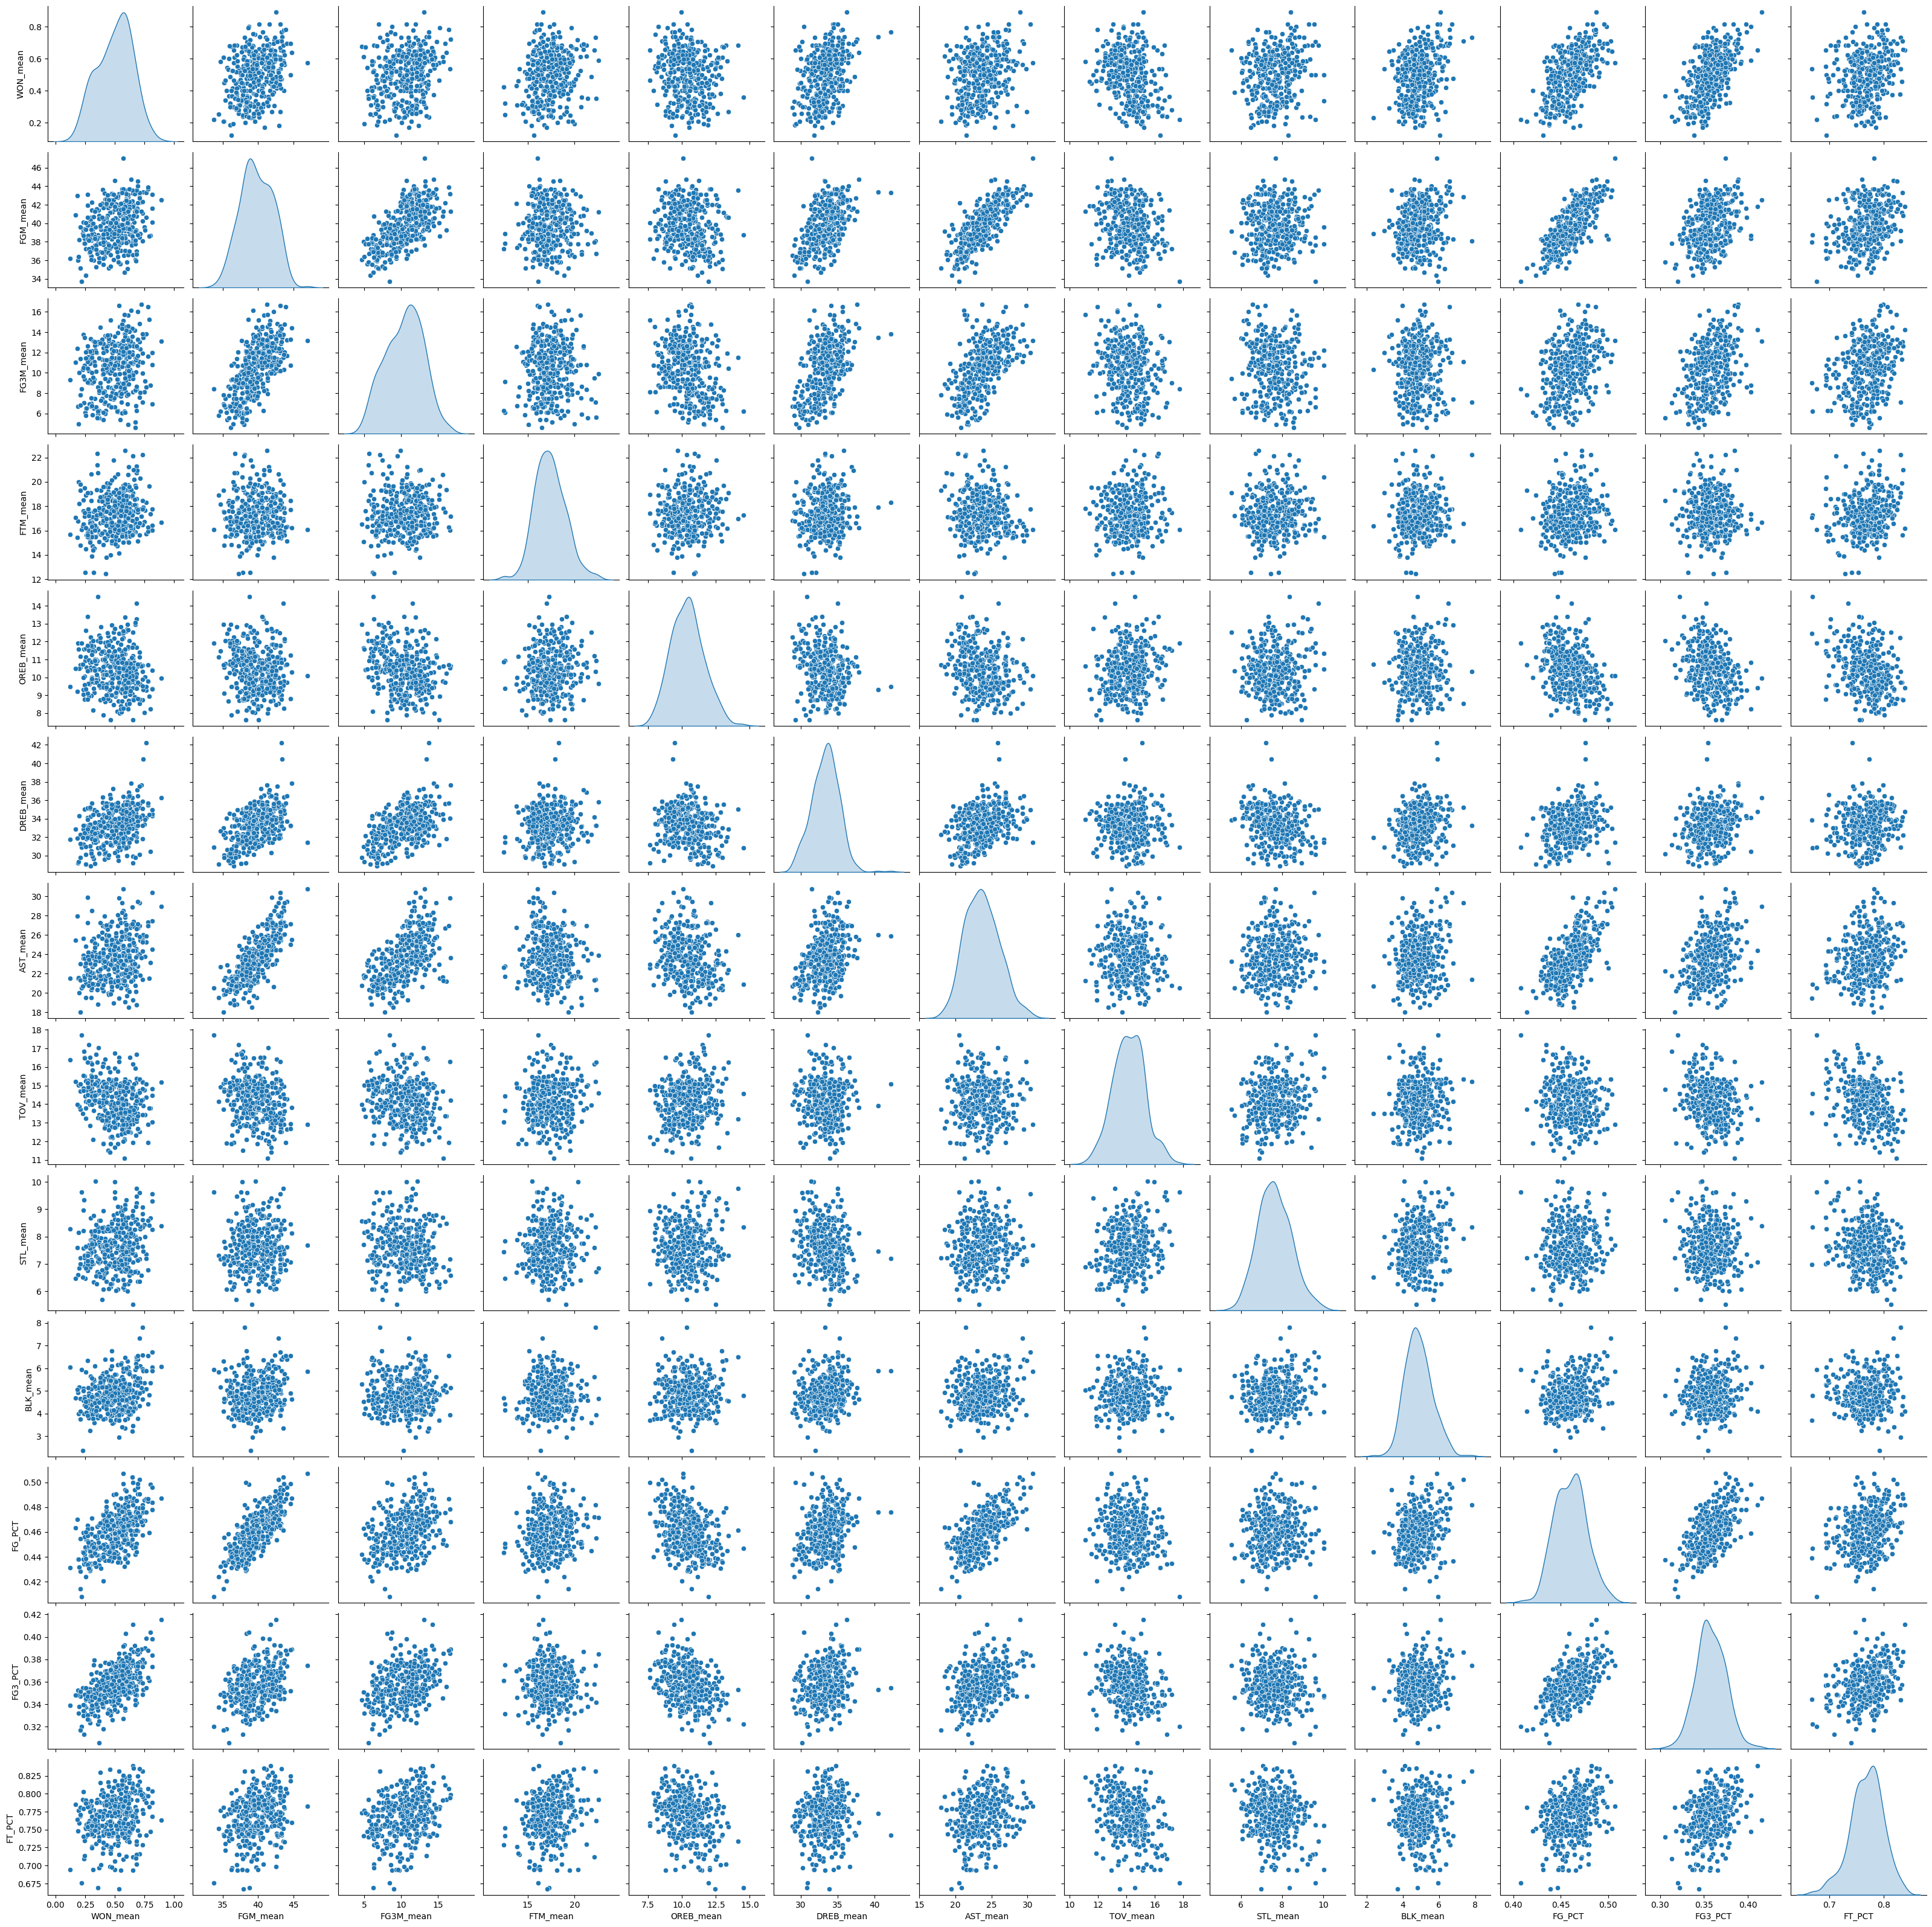

In [7]:
from seaborn import pairplot
pairplot(df.iloc[:,3:],diag_kind="kde")

## Assists appears to be highly correlated with Field Goals Made, as to be expected. However, this will add multicollinearity into our model so we should remove one of them.

In [8]:
df = df.drop("AST_mean",axis=1)

# Now lets transform our stats into z_scores so that we can interpret the coefs

In [9]:
from sklearn.preprocessing import StandardScaler

raw_X = df.iloc[:,4:]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(raw_X)
X_scaled = pd.DataFrame(X_scaled, columns=raw_X.columns)

# Now lets train our linear regression model

In [10]:
import statsmodels.api as sm

X = sm.add_constant(X_scaled)
y = df["WON_mean"]
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               WON_mean   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     138.1
Date:                Mon, 10 Nov 2025   Prob (F-statistic):          1.16e-119
Time:                        16:11:57   Log-Likelihood:                 479.55
No. Observations:                 360   AIC:                            -935.1
Df Residuals:                     348   BIC:                            -888.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4996      0.003    145.947      0.0

# Interpret Results

Looking at the results of model.summary() we can see first that our model does a pretty good job of predicting a team's win percentage with an R-squared of .814. We also see that we don't violate any of the assumptions for linear regression (Lower Table).

We can also tell which coefs have a significant effect on win percentage and which don't. We can ee that free throws made per game and blocks per game do not have a significant effect on win percentage. Next since we scaled the values in our model we can compare the coefs of the model to determine which statistics have a bigger impact on win percentage per change in 1 standard deviation. We see that the biggest impact is Field goals made per game however, interesting to note is the coef is negative indicating a negative relationship when all other variables are kept constant. This could represent a multitude of things such as the shift away from field goals to 3 pointers but this should prompt us to do a deeper dive into why this might be the case. We also can see that defensive rebounds are also very important to win percentage.

# Now lets look at how we can build a logistic regression model to model the probability a shot is a goal

The data we will be using is from statsbomb

Let's look at what competitions statsbomb provides us

In [11]:
from statsbombpy import sb
comps = sb.competitions()
comps.head()

competition_id  season_id country_name        competition_name  \
0               9        281      Germany           1. Bundesliga   
1               9         27      Germany           1. Bundesliga   
2            1267        107       Africa  African Cup of Nations   
3              16          4       Europe        Champions League   
4              16          1       Europe        Champions League   

  competition_gender  competition_youth  competition_international  \
0               male              False                      False   
1               male              False                      False   
2               male              False                       True   
3               male              False                      False   
4               male              False                      False   

  season_name               match_updated           match_updated_360  \
0   2023/2024  2024-09-28T20:46:38.893391  2025-07-06T04:26:07.636270   
1   2015/2016  2024-05-19T11:11:14.192381                        None   
2        2023  2024-09-28T01:57:35.846538                        None   
3   2018/2019  2025-05-08T15:10:50.835274     2021-06-13T16:17:31.694   
4   2017/2018  2024-02-13T02:35:28.134882     2021-06-13T16:17:31.694   

          match_available_360             match_available  
0  2025-07-06T04:26:07.636270  2024-09-28T20:46:38.893391  
1                        None  2024-05-19T11:11:14.192381  
2                        None  2024-09-28T01:57:35.846538  
3                        None  2025-05-08T15:10:50.835274  
4                        None  2024-02-13T02:35:28.134882

### Now lets see what games are available from the first competition

In [12]:
bundesliga_2023 = sb.matches(competition_id=9,season_id=281)
bundesliga_2023.head()

match_id  match_date      kick_off              competition     season  \
0   3895302  2024-04-14  17:30:00.000  Germany - 1. Bundesliga  2023/2024   
1   3895292  2024-04-06  15:30:00.000  Germany - 1. Bundesliga  2023/2024   
2   3895333  2024-05-05  18:30:00.000  Germany - 1. Bundesliga  2023/2024   
3   3895340  2024-05-12  20:30:00.000  Germany - 1. Bundesliga  2023/2024   
4   3895348  2024-05-18  16:30:00.000  Germany - 1. Bundesliga  2023/2024   

             home_team         away_team  home_score  away_score match_status  \
0     Bayer Leverkusen     Werder Bremen           5           0    available   
1         Union Berlin  Bayer Leverkusen           0           1    available   
2  Eintracht Frankfurt  Bayer Leverkusen           1           5    available   
3               Bochum  Bayer Leverkusen           0           5    available   
4     Bayer Leverkusen          Augsburg           2           1    available   

   ...            last_updated_360 match_week competition_stage  \
0  ...  2024-05-10T17:03:59.613154         29    Regular Season   
1  ...  2024-05-12T21:08:37.897296         28    Regular Season   
2  ...  2024-05-14T16:32:13.483516         32    Regular Season   
3  ...  2024-05-14T16:46:08.459843         33    Regular Season   
4  ...  2024-05-20T10:33:09.140760         34    Regular Season   

                          stadium              referee        home_managers  \
0                        BayArena          Harm Osmers  Xabier Alonso Olano   
1  Stadion An der Alten Försterei       Benjamin Brand        Nenad Bjelica   
2              Deutsche Bank Park    Christian Dingert      Dino Toppmöller   
3             Vonovia Ruhrstadion       Benjamin Brand       Heiko Butscher   
4                        BayArena  Matthias Jöllenbeck  Xabier Alonso Olano   

           away_managers data_version shot_fidelity_version  \
0             Ole Werner        1.1.0                     2   
1    Xabier Alonso Olano        1.1.0                     2   
2    Xabier Alonso Olano        1.1.0                     2   
3    Xabier Alonso Olano        1.1.0                     2   
4  Jess Christian Thorup        1.1.0                     2   

  xy_fidelity_version  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  

[5 rows x 22 columns]

### And what the events from the first match look like

In [13]:
test_match_events = sb.events(3895302)
test_match_events.head()

50_50 bad_behaviour_card ball_receipt_outcome  \
0   NaN                NaN                  NaN   
1   NaN                NaN                  NaN   
2   NaN                NaN                  NaN   
3   NaN                NaN                  NaN   
4   NaN                NaN                  NaN   

  ball_recovery_recovery_failure block_deflection block_save_block  \
0                            NaN              NaN              NaN   
1                            NaN              NaN              NaN   
2                            NaN              NaN              NaN   
3                            NaN              NaN              NaN   
4                            NaN              NaN              NaN   

  carry_end_location clearance_aerial_won clearance_body_part clearance_head  \
0                NaN                  NaN                 NaN            NaN   
1                NaN                  NaN                 NaN            NaN   
2                NaN                  NaN                 NaN            NaN   
3                NaN                  NaN                 NaN            NaN   
4                NaN                  NaN                 NaN            NaN   

   ... substitution_outcome substitution_outcome_id substitution_replacement  \
0  ...                  NaN                     NaN                      NaN   
1  ...                  NaN                     NaN                      NaN   
2  ...                  NaN                     NaN                      NaN   
3  ...                  NaN                     NaN                      NaN   
4  ...                  NaN                     NaN                      NaN   

  substitution_replacement_id  \
0                         NaN   
1                         NaN   
2                         NaN   
3                         NaN   
4                         NaN   

                                             tactics              team  \
0  {'formation': 3421, 'lineup': [{'player': {'id...  Bayer Leverkusen   
1  {'formation': 352, 'lineup': [{'player': {'id'...     Werder Bremen   
2                                                NaN  Bayer Leverkusen   
3                                                NaN     Werder Bremen   
4                                                NaN  Bayer Leverkusen   

  team_id     timestamp         type under_pressure  
0     904  00:00:00.000  Starting XI            NaN  
1     176  00:00:00.000  Starting XI            NaN  
2     904  00:00:00.000   Half Start            NaN  
3     176  00:00:00.000   Half Start            NaN  
4     904  00:00:00.000   Half Start            NaN  

[5 rows x 91 columns]

### Since we are only concerned with modelng for shots lets filter the events down to just shots and disregard penalties

In [14]:
shots = test_match_events[(test_match_events.type=="Shot") & (test_match_events.shot_type != "Penalty")]
shots = shots.loc[:, shots.notnull().any()]
shots.head()

duration                                    id  index       location  \
4093  0.052872  c577e730-b9f5-44f2-9257-9e7730c23d7b    436  [100.4, 35.1]   
4094  0.217872  bbc2c68d-c096-483d-abf4-32c0175a0f55    480  [114.6, 33.5]   
4095  0.445768  12b5206b-9ed0-4b1e-9ec3-f2028187e09f    597  [106.2, 55.8]   
4096  0.085298  b2c3d59d-3bef-4f8a-ad86-26b69940c64e    684  [113.9, 47.4]   
4097  0.402989  bb53b537-1685-4019-9e8f-98f3805828eb    848   [89.2, 42.5]   

      match_id  minute  period    play_pattern                       player  \
4093   3895302       6       1  From Free Kick         Leonardo Bittencourt   
4094   3895302       7       1    Regular Play  Piero Martín Hincapié Reyna   
4095   3895302      11       1  From Free Kick              Julián Malatini   
4096   3895302      13       1     From Corner                 Jonathan Tah   
4097   3895302      16       1    Regular Play                 Granit Xhaka   

      player_id  ... shot_one_on_one  shot_outcome shot_statsbomb_xg  \
4093     8826.0  ...             NaN       Blocked          0.056644   
4094    38004.0  ...             NaN         Saved          0.143381   
4095    51769.0  ...             NaN       Blocked          0.038188   
4096     8221.0  ...             NaN       Blocked          0.052781   
4097     3500.0  ...             NaN       Blocked          0.021272   

      shot_technique  shot_type              team team_id     timestamp  type  \
4093          Normal  Open Play     Werder Bremen     176  00:06:48.773  Shot   
4094          Normal  Open Play  Bayer Leverkusen     904  00:07:40.953  Shot   
4095          Normal  Open Play     Werder Bremen     176  00:11:08.471  Shot   
4096          Normal  Open Play  Bayer Leverkusen     904  00:13:16.073  Shot   
4097          Normal  Open Play  Bayer Leverkusen     904  00:16:00.956  Shot   

     under_pressure  
4093            NaN  
4094           True  
4095            NaN  
4096            NaN  
4097           True  

[5 rows x 32 columns]

### Columns available

In [15]:
shots.columns

Index(['duration', 'id', 'index', 'location', 'match_id', 'minute', 'period',
       'play_pattern', 'player', 'player_id', 'position', 'possession',
       'possession_team', 'possession_team_id', 'related_events', 'second',
       'shot_aerial_won', 'shot_body_part', 'shot_end_location',
       'shot_first_time', 'shot_freeze_frame', 'shot_key_pass_id',
       'shot_one_on_one', 'shot_outcome', 'shot_statsbomb_xg',
       'shot_technique', 'shot_type', 'team', 'team_id', 'timestamp', 'type',
       'under_pressure'],
      dtype='object')

## Now let's look at the columns relevant to each shot

In [16]:
shots["x"] = shots["location"].str[0]
shots["y"] = shots["location"].str[1]
shot_features = [ 'shot_body_part','shot_first_time', 'shot_freeze_frame','shot_one_on_one', 'shot_outcome', 'shot_statsbomb_xg','shot_technique','under_pressure',"x","y"]
shots_filtered = shots[shot_features]
shots_filtered

shot_body_part shot_first_time  \
4093     Right Foot            True   
4094      Left Foot            True   
4095      Left Foot            True   
4096           Head             NaN   
4097      Left Foot             NaN   
4098           Head             NaN   
4099     Right Foot             NaN   
4101      Left Foot            True   
4102           Head             NaN   
4103     Right Foot            True   
4104     Right Foot             NaN   
4105      Left Foot             NaN   
4106           Head             NaN   
4107           Head             NaN   
4108      Left Foot             NaN   
4109     Right Foot             NaN   
4110      Left Foot            True   
4111     Right Foot             NaN   
4112     Right Foot             NaN   
4113      Left Foot            True   
4114     Right Foot             NaN   
4115      Left Foot             NaN   
4116     Right Foot            True   
4117     Right Foot            True   
4118     Right Foot             NaN   
4119     Right Foot             NaN   

                                      shot_freeze_frame shot_one_on_one  \
4093  [{'location': [101.9, 35.1], 'player': {'id': ...             NaN   
4094  [{'location': [92.1, 63.8], 'player': {'id': 8...             NaN   
4095  [{'location': [118.2, 42.9], 'player': {'id': ...             NaN   
4096  [{'location': [117.1, 37.7], 'player': {'id': ...             NaN   
4097  [{'location': [103.8, 39.7], 'player': {'id': ...             NaN   
4098  [{'location': [114.1, 38.0], 'player': {'id': ...             NaN   
4099  [{'location': [100.3, 62.3], 'player': {'id': ...             NaN   
4101  [{'location': [117.8, 41.1], 'player': {'id': ...             NaN   
4102  [{'location': [115.2, 39.4], 'player': {'id': ...             NaN   
4103  [{'location': [114.7, 49.3], 'player': {'id': ...             NaN   
4104  [{'location': [101.3, 30.5], 'player': {'id': ...             NaN   
4105  [{'location': [118.2, 35.0], 'player': {'id': ...             NaN   
4106  [{'location': [117.7, 75.3], 'player': {'id': ...             NaN   
4107  [{'location': [96.9, 40.3], 'player': {'id': 3...            True   
4108  [{'location': [101.1, 33.9], 'player': {'id': ...             NaN   
4109  [{'location': [109.0, 50.7], 'player': {'id': ...             NaN   
4110  [{'location': [118.6, 39.9], 'player': {'id': ...             NaN   
4111  [{'location': [91.8, 22.5], 'player': {'id': 3...             NaN   
4112  [{'location': [116.7, 39.9], 'player': {'id': ...             NaN   
4113  [{'location': [115.1, 52.2], 'player': {'id': ...             NaN   
4114  [{'location': [109.3, 44.8], 'player': {'id': ...             NaN   
4115  [{'location': [109.9, 36.2], 'player': {'id': ...             NaN   
4116  [{'location': [116.0, 40.7], 'player': {'id': ...             NaN   
4117  [{'location': [109.2, 50.1], 'player': {'id': ...             NaN   
4118  [{'location': [93.4, 47.1], 'player': {'id': 6...            True   
4119  [{'location': [104.1, 50.3], 'player': {'id': ...             NaN   

     shot_outcome  shot_statsbomb_xg shot_technique under_pressure      x  \
4093      Blocked           0.056644         Normal            NaN  100.4   
4094        Saved           0.143381         Normal           True  114.6   
4095      Blocked           0.038188         Normal            NaN  106.2   
4096      Blocked           0.052781         Normal            NaN  113.9   
4097      Blocked           0.021272         Normal           True   89.2   
4098      Wayward           0.029664         Normal           True  110.2   
4099      Blocked           0.082293         Normal           True  105.4   
4101      Blocked           0.050110         Normal            NaN  101.5   
4102        Saved           0.109917         Normal           True  116.3   
4103        Saved           0.323069         Volley            NaN  116.3   
4104      Blocked           0.095424         Normal            NaN  109.4   
4

### Quickly plot all the shots

Key note: Shots were already normalized to be left to right for the team performing the action so we don't end up needing to do transformation here

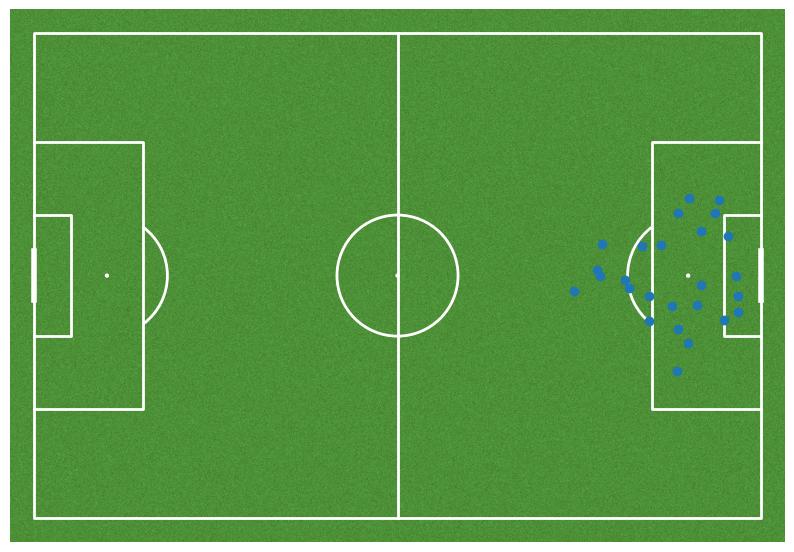

In [17]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch


pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)
plt.scatter(x=shots_filtered["x"],y=shots_filtered["y"])
plt.show()

## Now let's engineer some features that describe each shot

In [18]:
shots_filtered["distance_from_goal"] = np.sqrt( (shots_filtered["x"] - 120) ** 2 + (shots_filtered["y"] - 40) ** 2)
shots_filtered["angle_to_goal_rad"] = np.arctan2(40 - shots_filtered["y"], 120 - shots_filtered["x"])

#Compute the angle between shot and left post and shot and right post
posts_left = np.array([120, 36])
posts_right = np.array([120, 44])
shots_points = shots_filtered[['x', 'y']].to_numpy()

vec_left = posts_left - shots_points  # Vector from shot to left post
vec_right = posts_right - shots_points  # Vector from shot to right post

dot_prod = np.einsum('ij,ij->i', vec_left, vec_right)
norm_left = np.linalg.norm(vec_left, axis=1)
norm_right = np.linalg.norm(vec_right, axis=1)

shots_filtered['shot_angle'] = np.arccos(dot_prod / (norm_left * norm_right))

# Fix enconding of boolean columns
shots_filtered["shot_first_time"] = shots_filtered["shot_first_time"]==True
shots_filtered["shot_one_on_one"] = shots_filtered["shot_one_on_one"]==True
shots_filtered["under_pressure"] = shots_filtered["under_pressure"]==True
shots_filtered["shot_outcome"] = shots_filtered["shot_outcome"] == "Goal"

#One hot encode body part and technique
shot_body_dummies = pd.get_dummies(shots_filtered['shot_body_part'], prefix='body_part',drop_first=True) # Drop first to avoid multicollinearity
shots_filtered = pd.concat([shots_filtered, shot_body_dummies], axis=1)

shot_body_dummies = pd.get_dummies(shots_filtered['shot_technique'], prefix='technique',drop_first=True)
shots_filtered = pd.concat([shots_filtered, shot_body_dummies], axis=1)

shots_filtered =shots_filtered.drop(["shot_body_part","shot_technique"],axis=1)
shots_filtered

shot_first_time                                  shot_freeze_frame  \
4093             True  [{'location': [101.9, 35.1], 'player': {'id': ...   
4094             True  [{'location': [92.1, 63.8], 'player': {'id': 8...   
4095             True  [{'location': [118.2, 42.9], 'player': {'id': ...   
4096            False  [{'location': [117.1, 37.7], 'player': {'id': ...   
4097            False  [{'location': [103.8, 39.7], 'player': {'id': ...   
4098            False  [{'location': [114.1, 38.0], 'player': {'id': ...   
4099            False  [{'location': [100.3, 62.3], 'player': {'id': ...   
4101             True  [{'location': [117.8, 41.1], 'player': {'id': ...   
4102            False  [{'location': [115.2, 39.4], 'player': {'id': ...   
4103             True  [{'location': [114.7, 49.3], 'player': {'id': ...   
4104            False  [{'location': [101.3, 30.5], 'player': {'id': ...   
4105            False  [{'location': [118.2, 35.0], 'player': {'id': ...   
4106            False  [{'location': [117.7, 75.3], 'player': {'id': ...   
4107            False  [{'location': [96.9, 40.3], 'player': {'id': 3...   
4108            False  [{'location': [101.1, 33.9], 'player': {'id': ...   
4109            False  [{'location': [109.0, 50.7], 'player': {'id': ...   
4110             True  [{'location': [118.6, 39.9], 'player': {'id': ...   
4111            False  [{'location': [91.8, 22.5], 'player': {'id': 3...   
4112            False  [{'location': [116.7, 39.9], 'player': {'id': ...   
4113             True  [{'location': [115.1, 52.2], 'player': {'id': ...   
4114            False  [{'location': [109.3, 44.8], 'player': {'id': ...   
4115            False  [{'location': [109.9, 36.2], 'player': {'id': ...   
4116             True  [{'location': [116.0, 40.7], 'player': {'id': ...   
4117             True  [{'location': [109.2, 50.1], 'player': {'id': ...   
4118            False  [{'location': [93.4, 47.1], 'player': {'id': 6...   
4119            False  [{'location': [104.1, 50.3], 'player': {'id': ...   

      shot_one_on_one  shot_outcome  shot_statsbomb_xg  under_pressure      x  \
4093            False         False           0.056644           False  100.4   
4094            False         False           0.143381            True  114.6   
4095            False         False           0.038188           False  106.2   
4096            False         False           0.052781           False  113.9   
4097            False         False           0.021272            True   89.2   
4098            False         False           0.029664            True  110.2   
4099            False         False           0.082293            True  105.4   
4101            False         False           0.050110           False  101.5   
4102            False         False           0.109917            True  116.3   
4103            False         False           0.323069           False  116.3   
4104            False         False           0.095424           False  109.4   
4105            False         False           0.074157            True  113.1   
4106            False         False           0.067553           False  110.1   
4107             True         False           0.375736           False  115.9   
4108            False         False           0.048408            True   97.5   
4109            False         False           0.024202            True   93.8   
4110            False          True           0.031473           False   93.0   
4111            False         False           0.076220           False  106.3   
4112            False          True           0.042012           False   93.5   
4113            False         False           0.109270           False  112.5   
4114            False         False           0.173471           False  108.0   
4115            False         False           0.047987           False  108.1   
4116            False         False           0.034476           False   98.2   
4117     

## Now we will collect this information for all the shots in all the games from whatever competition we are considering

For sake of time I have already run this and saved the data to a csv.

In [19]:
# from tqdm import tqdm

# def preprocessing(match_events):
#     shots = match_events[(match_events.type=="Shot") & (match_events.shot_type != "Penalty")]
#     shots["x"] = shots["location"].str[0]
#     shots["y"] = shots["location"].str[1]
#     shot_features = [ 'shot_body_part','shot_first_time', 'shot_freeze_frame', 'shot_outcome', 'shot_statsbomb_xg','shot_technique','under_pressure',"x","y"] #shot_one_on_one
#     shots_filtered = shots[shot_features]
#     shots_filtered["distance_from_goal"] = np.sqrt( (shots_filtered["x"] - 120) ** 2 + (shots_filtered["y"] - 40) ** 2)
#     shots_filtered["angle_to_goal_rad"] = np.arctan2(40 - shots_filtered["y"], 120 - shots_filtered["x"])

#     #Compute the angle between shot and left post and shot and right post
#     posts_left = np.array([120, 36])
#     posts_right = np.array([120, 44])
#     shots_points = shots_filtered[['x', 'y']].to_numpy()

#     vec_left = posts_left - shots_points  # Vector from shot to left post
#     vec_right = posts_right - shots_points  # Vector from shot to right post

#     dot_prod = np.einsum('ij,ij->i', vec_left, vec_right)
#     norm_left = np.linalg.norm(vec_left, axis=1)
#     norm_right = np.linalg.norm(vec_right, axis=1)

#     shots_filtered['shot_angle'] = np.arccos(dot_prod / (norm_left * norm_right))

#     return shots_filtered


# dfs = []
# season_id = 27
# competition_ids = [9,11,7,2,12]
# for competition_id in competition_ids:
#     matches = sb.matches(competition_id,season_id)
#     for match_id in tqdm(matches.match_id,"Finding Shots:"):
#         dfs.append(preprocessing(sb.events(match_id=match_id)))
# model_df = pd.concat(dfs)

# # Fix enconding of boolean columns
# model_df["shot_first_time"] = model_df["shot_first_time"]==True
# #shots_filtered["shot_one_on_one"] = shots_filtered["shot_one_on_one"]==True
# model_df["under_pressure"] = model_df["under_pressure"]==True
# model_df["shot_outcome"] = model_df["shot_outcome"] == "Goal"

# #One hot encode body part and technique
# shot_body_dummies = pd.get_dummies(model_df['shot_body_part'], prefix='body_part',drop_first=True) # Drop first to avoid multicollinearity
# model_df = pd.concat([model_df, shot_body_dummies], axis=1)

# shot_body_dummies = pd.get_dummies(model_df['shot_technique'], prefix='technique',drop_first=True)
# model_df = pd.concat([model_df, shot_body_dummies], axis=1)

# model_df =model_df.drop(["shot_body_part","shot_technique"],axis=1)

In [20]:
model_df = pd.read_csv("shots_model_df_train.csv")
model_df

shot_first_time  shot_outcome  shot_statsbomb_xg  under_pressure  \
0                 True         False           0.087901           False   
1                 True          True           0.160274           False   
2                 True         False           0.016036            True   
3                False          True           0.527759           False   
4                False         False           0.074020           False   
...                ...           ...                ...             ...   
45228            False         False           0.030999            True   
45229             True         False           0.042634           False   
45230             True         False           0.038101           False   
45231            False         False           0.063746           False   
45232            False         False           0.006685            True   

           x     y  distance_from_goal  angle_to_goal_rad  shot_angle  \
0      108.1  31.2           14.800338           0.636744    0.438419   
1      110.9  42.6            9.464143          -0.278300    0.780138   
2      117.9  29.1           11.100450           1.380468    0.155423   
3      101.8  27.6           22.022716           0.598078    0.301014   
4      109.3  26.5           17.226143           0.900588    0.295954   
...      ...   ...                 ...                ...         ...   
45228   98.6  40.4           21.403738          -0.018689    0.369445   
45229  103.0  51.3           20.412986          -0.586644    0.327214   
45230  103.8  51.4           19.809089          -0.613207    0.331601   
45231  110.0  39.4           10.017984           0.059928    0.758877   
45232  115.2  19.0           21.541588           1.346085    0.085498   

       body_part_Left Foot  body_part_Other  body_part_Right Foot  \
0                     True            False                 False   
1                    False            False                  True   
2                     True            False                 False   
3                     True            False                 False   
4                    False            False                  True   
...                    ...              ...                   ...   
45228                 True            False                 False   
45229                 True            False                 False   
45230                False            False                  True   
45231                False            False                 False   
45232                 True            False                 False   

       technique_Diving Header  technique_Half Volley  technique_Lob  \
0                        False                   True          False   
1                        False                  False          False   
2                        False                   True          False   
3                        False                  False          False   
4                        False                  False          False   
...                        ...                    ...            ...   
45228                    False                  False          False   
45229                    False                  False          False   
45230                    False                   True          False   
45231                    False                  False          False   
45232                    False                  False          False   

       technique_Normal  technique_Overhead Kick  technique_Volley  
0                 False                    False             False  
1                 False                    False              True  
2                 False                    False             False  
3                  True                    False             False  
4                  True                    False             False  
...                 ...                      ...               ...  
45228              True                    False    

## We will work with the freeze frames in a second for now let's train our basic model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

X = model_df.loc[:, ~model_df.columns.isin(["shot_outcome", "shot_statsbomb_xg"])]
X = X.astype(float)
X = sm.add_constant(X)

y = model_df["shot_outcome"]

n=X.shape[0]
test_size = int(0.25 * n)
test_indices = np.random.choice(n, size=test_size, replace=False)
# Get training indices as all remaining ones
train_indices = np.setdiff1d(np.arange(n), test_indices)

# Use indices to create splits
X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

model = sm.Logit(y_train, X_train).fit()
print(model.summary())
print()

y_pred_test = model.predict(X_test)
print("Logistic Loss:", log_loss(y_test,y_pred_test))
print("AUC:",roc_auc_score(y_test,y_pred_test))

Optimization terminated successfully.
         Current function value: 0.264259
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           shot_outcome   No. Observations:                33925
Model:                          Logit   Df Residuals:                    33908
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.1659
Time:                        16:20:20   Log-Likelihood:                -8965.0
converged:                       True   LL-Null:                       -10748.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.9989      1.327      1.507      0.132      -0.601   

## Now let's visualize the AUC and ECE Curves for model performance

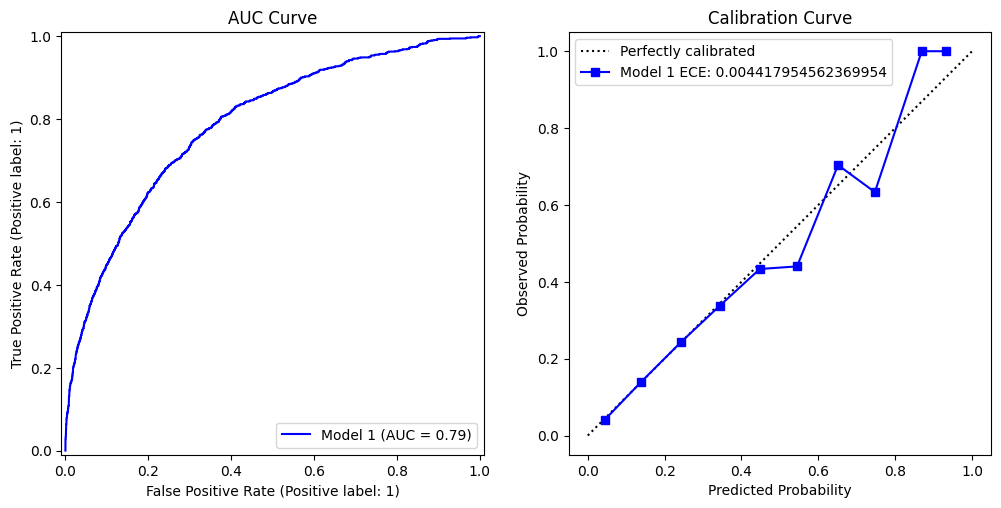

In [23]:
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

def compute_ece(y_true, y_proba, n_bins=10):
    """
    computes expected calibration error for a binary classifier
    :param y_true: vector of true classes
    :param y_proba: vector of predicted probabilities
    :param n_bins: 10
    :return:ece
    """

    # pre-process to improve binning
    sort_idx = np.argsort(y_proba)
    y_pred = y_proba[sort_idx]
    y_true = y_true[sort_idx] > 0
    n = len(y_true)

    acc = np.zeros(n_bins)
    conf = np.zeros(n_bins)
    counts = np.zeros(n_bins)

    for k in range(n_bins):
        left_idx = np.searchsorted(y_pred, k / n_bins, side='left')
        right_idx = np.searchsorted(y_pred, (k + 1) / n_bins, side='right')
        if left_idx < right_idx:
            bin_idx = np.arange(left_idx, right_idx)
            counts[k] = len(bin_idx)
            conf[k] = np.mean(y_pred[bin_idx])
            acc[k] = np.mean(y_true[bin_idx])

    ece = np.sum(counts * np.abs(acc - conf)) / n
    return ece

def plot_roc_curve(y_true, y_pred, ax, label="Model", color="blue"):
    """
    Plot ROC curve with a custom legend label.
    """
    disp = RocCurveDisplay.from_predictions(
        y_true, y_pred, ax=ax, color=color, name=label
    )
    ax.legend(loc="lower right")
    return disp


def plot_reliability_diagram(y_true, y_pred, ax, label="Model", color="blue", n_bins=10):
    """
    Plot reliability diagram (calibration curve) with custom legend label.
    """
    disp = CalibrationDisplay.from_predictions(
        y_true, y_pred, strategy="uniform", ax=ax, n_bins=n_bins, color=color, name=label
    )
    ax.legend(loc="upper left")
    return disp

fig, ax = plt.subplots(1, 2, figsize = (12, 12))
ax[0].set_aspect('equal', adjustable='box') # roc curve
ax[1].set_aspect('equal', adjustable='box') # reliability diagram

# Your Code Here
# Use plot_roc_curve(), plot_reliability_diagram()
plot_roc_curve(y_test,y_pred_test,ax=ax[0],color="blue",label="Model 1")
plot_reliability_diagram(y_test,y_pred_test,ax=ax[1],color="blue",label = f"Model 1 ECE: {compute_ece(y_test.values,y_pred_test.values)}")

ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Observed Probability")
ax[1].set_title(f"Calibration Curve")

ax[0].set_title("AUC Curve")
plt.show()

In [24]:
model_outputs = pd.concat([X,model.predict(X)],axis=1).rename({0:"xG"},axis=1)
model_outputs

technique_cols = [col for col in model_outputs.columns if col.startswith("technique_")]
body_part_cols = [col for col in model_outputs.columns if col.startswith("body_part_")]

# Restore technique column
model_outputs["technique"] = model_outputs[technique_cols].idxmax(axis=1).str.replace("technique_", "")
model_outputs.loc[model_outputs[technique_cols].sum(axis=1) == 0, "technique"] = "Backheel"

# Restore body_part column
model_outputs["body_part"] = model_outputs[body_part_cols].idxmax(axis=1).str.replace("body_part_", "")
model_outputs.loc[model_outputs[body_part_cols].sum(axis=1) == 0, "body_part"] = "Head"
model_outputs

const  shot_first_time  under_pressure      x     y  \
0        1.0              1.0             0.0  108.1  31.2   
1        1.0              1.0             0.0  110.9  42.6   
2        1.0              1.0             1.0  117.9  29.1   
3        1.0              0.0             0.0  101.8  27.6   
4        1.0              0.0             0.0  109.3  26.5   
...      ...              ...             ...    ...   ...   
45228    1.0              0.0             1.0   98.6  40.4   
45229    1.0              1.0             0.0  103.0  51.3   
45230    1.0              1.0             0.0  103.8  51.4   
45231    1.0              0.0             0.0  110.0  39.4   
45232    1.0              0.0             1.0  115.2  19.0   

       distance_from_goal  angle_to_goal_rad  shot_angle  body_part_Left Foot  \
0               14.800338           0.636744    0.438419                  1.0   
1                9.464143          -0.278300    0.780138                  0.0   
2               11.100450           1.380468    0.155423                  1.0   
3               22.022716           0.598078    0.301014                  1.0   
4               17.226143           0.900588    0.295954                  0.0   
...                   ...                ...         ...                  ...   
45228           21.403738          -0.018689    0.369445                  1.0   
45229           20.412986          -0.586644    0.327214                  1.0   
45230           19.809089          -0.613207    0.331601                  0.0   
45231           10.017984           0.059928    0.758877                  0.0   
45232           21.541588           1.346085    0.085498                  1.0   

       body_part_Other  body_part_Right Foot  technique_Diving Header  \
0                  0.0                   0.0                      0.0   
1                  0.0                   1.0                      0.0   
2                  0.0                   0.0                      0.0   
3                  0.0                   0.0                      0.0   
4                  0.0                   1.0                      0.0   
...                ...                   ...                      ...   
45228              0.0                   0.0                      0.0   
45229              0.0                   0.0                      0.0   
45230              0.0                   1.0                      0.0   
45231              0.0                   0.0                      0.0   
45232              0.0                   0.0                      0.0   

       technique_Half Volley  technique_Lob  technique_Normal  \
0                        1.0            0.0               0.0   
1                        0.0            0.0               0.0   
2                        1.0            0.0               0.0   
3                        0.0            0.0               1.0   
4                        0.0            0.0               1.0   
...                      ...            ...               ...   
45228                    0.0            0.0               1.0   
45229                    0.0            0.0               1.0   
45230                    1.0            0.0               0.0   
45231                    0.0            0.0               1.0   
45232                    0.0            0.0               1.0   

       technique_Overhead Kick  technique_Volley        xG    technique  \
0                          0.0               0.0  0.086711  Half Volley   
1                          0.0               1.0  0.248771       Volley   
2                          0.0               0.0  0.053023  Half Volley   
3                          0.0               0.0  0.061491       Normal   
4                          0.0               0.0  0.102789       Normal   
...                        ...               ...       ...          ...   
45228                      0.0               0.0  0.062424       Normal   
45229                      0.0 

## Lets now visualize some of these predictions

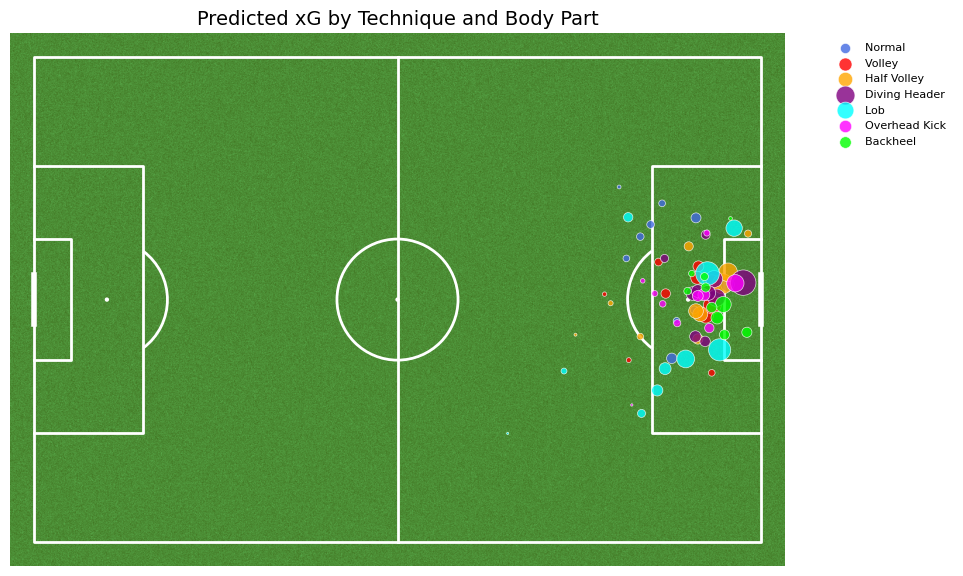

In [25]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Define color palette and marker shapes
technique_colors = {
    'Normal': 'royalblue',
    'Volley': 'red',
    'Half Volley': 'orange',
    'Diving Header': 'purple',
    'Lob': 'cyan',
    'Overhead Kick': 'magenta',
    'Backheel': 'lime'
}

body_part_markers = {
    'Right Foot': 'o',
    'Left Foot': 's',
    'Head': '^',
    'Other': 'X'
}

# Plot by technique and body part
for technique, color in technique_colors.items():
    # for body_part, marker in body_part_markers.items():
        subset = model_outputs[
            (model_outputs["technique"] == technique) #&
            #(model_outputs["body_part"] == body_part)
        ].iloc[:10]  # limit for clarity
        if subset.shape[0]==0:
            continue
        ax.scatter(
            subset["x"],
            subset["y"],
            s=subset["xG"] * 500,
            c=color,
            marker="o", # Can make the marker by body part
            edgecolor="white",
            linewidth=0.5,
            alpha=0.8,
            label=f"{technique} "#| {body_part}"
        )

plt.title("Predicted xG by Technique and Body Part", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, frameon=False)
plt.show()
    

# Now let's incorporate features from the freeze frames and compare the model performance

Let's see an example of what a free frame looks like

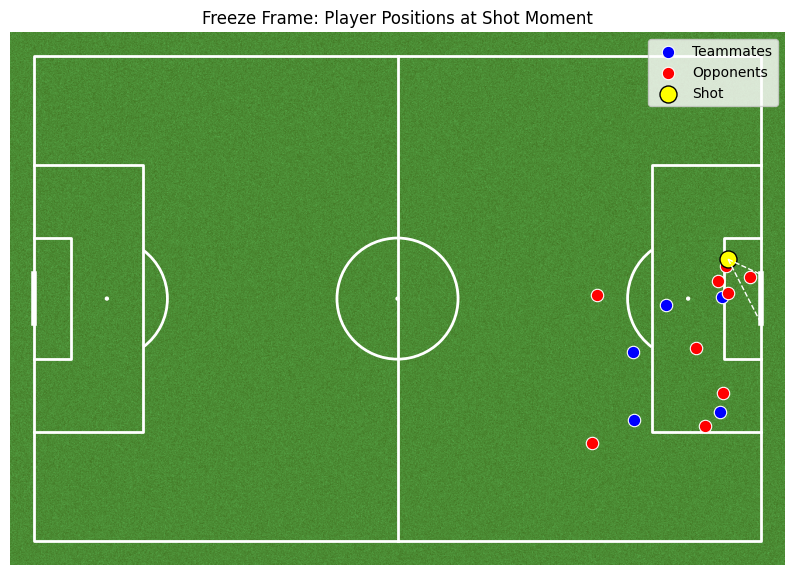

In [29]:
frame_number = 1 # 0, 1, 4 are good different examples 
freeze_frame = shots_filtered["shot_freeze_frame"].iloc[frame_number]

# Split into teammates and opponents
teammates = [p for p in freeze_frame if p["teammate"]]
opponents = [p for p in freeze_frame if not p["teammate"]]

# Extract coordinates
teammate_x = [p["location"][0] for p in teammates]
teammate_y = [p["location"][1] for p in teammates]
opponent_x = [p["location"][0] for p in opponents]
opponent_y = [p["location"][1] for p in opponents]

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Plot players
ax.scatter(teammate_x, teammate_y, c='blue', label='Teammates', s=80, edgecolors='white', linewidth=0.8)
ax.scatter(opponent_x, opponent_y, c='red', label='Opponents', s=80, edgecolors='white', linewidth=0.8)

# Optionally: add the shot location itself
shot_x, shot_y = shots_filtered.iloc[frame_number, [6,7]]
ax.scatter(shot_x, shot_y, c='yellow', s=150, edgecolors='black', label='Shot')

# Define goalpost coordinates (StatsBomb pitch: goal centered at y=40, posts at y=36 and y=44, x=120)
left_post = (120, 36)
right_post = (120, 44)
# Draw lines from shot to each post
ax.plot([shot_x, left_post[0]], [shot_y, left_post[1]], color='white', linestyle='--', linewidth=1)
ax.plot([shot_x, right_post[0]], [shot_y, right_post[1]], color='white', linestyle='--', linewidth=1)

# Legend + title
ax.legend(loc='upper right')
plt.title("Freeze Frame: Player Positions at Shot Moment")
plt.show()

# Now let's add some more features to capture the context at the moment of the shot.

 - Amount of opponent's in the way of the shot
 - Distance to the closest defender
 - Gk's positioning
 - Angle to GK
 - How much "free" angle is there to shoot (total goal angle - angle covered by defenders)
 - Percentage of angle that is "free"

In [30]:
# Goalposts and helper constants
GOAL_LEFT = np.array([120, 36])
GOAL_RIGHT = np.array([120, 44])
PLAYER_RADIUS = 1.0  # rough player blocking radius (m)

def extract_xy(players):
    """Extract x,y arrays from a freeze frame list of dicts."""
    x = np.array([p["location"][0] for p in players])
    y = np.array([p["location"][1] for p in players])
    return np.column_stack((x, y))

def angle_between(a, b):
    """Angle between vectors a and b."""
    dot = np.dot(a, b)
    return np.arccos(dot / (np.linalg.norm(a) * np.linalg.norm(b)))

shot_loc = np.array([shot_x, shot_y])

# Split teammates / opponents
teammates = [p for p in freeze_frame if p["teammate"]]
opponents = [p for p in freeze_frame if not p["teammate"]]
opp_xy = extract_xy(opponents)
team_xy = extract_xy(teammates)

# Compute total shooting cone angle (goal angle)
v_left = GOAL_LEFT - shot_loc
v_right = GOAL_RIGHT - shot_loc
goal_angle = angle_between(v_left, v_right)

### Distance to closest defender
dists_to_def = np.linalg.norm(opp_xy - shot_loc, axis=1)
dist_to_nearest_def = np.min(dists_to_def) if len(dists_to_def) > 0 else np.nan

left_post_angle = np.arctan2(GOAL_LEFT[1] - shot_y, GOAL_LEFT[0] - shot_x)
right_post_angle = np.arctan2(GOAL_RIGHT[1] - shot_y, GOAL_RIGHT[0] - shot_x)

# We are going to assume a player is 1m wide
#left side of body
l_dx = opp_xy[:, 0] - shot_loc[0]
l_dy = opp_xy[:, 1] - .5 - shot_loc[1]
l_opp_angles = np.arctan2(l_dy, l_dx)
#right side of body
r_dx = opp_xy[:, 0] - shot_loc[0]
r_dy = opp_xy[:, 1] + .5 - shot_loc[1]
r_opp_angles = np.arctan2(r_dy, r_dx)

# defender blocking intervals
blocked = []
for l, r in zip(l_opp_angles, r_opp_angles):
    # normalize each so left < right
    blocked.append(sorted([l, r]))

# clip to only those that actually overlap the goal angle
blocked = [
    [max(l, left_post_angle), min(r, right_post_angle)]
    for l, r in blocked
    if r > left_post_angle and l < right_post_angle
]

# sort by starting angle
blocked.sort(key=lambda x: x[0])

# now merge overlapping blocked ranges
merged = []
for b in blocked:
    if not merged or b[0] > merged[-1][1]:
        merged.append(b)
    else:
        merged[-1][1] = max(merged[-1][1], b[1])

# compute free (unblocked) angular segments
free_angles = []
cur = left_post_angle
for b in merged:
    if b[0] > cur:
        free_angles.append([cur, b[0]])  # free gap before blocked zone
    cur = b[1]
if cur < right_post_angle:
    free_angles.append([cur, right_post_angle])

free_angles = np.array(free_angles)

num_def_blocking = len(blocked)
total_free_angle = np.sum(free_angles[:,1] - free_angles[:,0]) ##### Key metric
percent_free_angle = total_free_angle / goal_angle

### Goalkeeper stats
gk_idx = np.argmax(opp_xy[:, 0])

gk_position = opp_xy[gk_idx]

gk_off_line = 120-gk_position[1]
gk_position_in_goal = 40-gk_position[0]
angle_shot_to_gk = np.arctan2(gk_position[1]-shot_loc[1], gk_position[0]-shot_loc[0])

print(num_def_blocking,goal_angle,total_free_angle,percent_free_angle)
print("Free angular intervals (radians):")
print(free_angles)

1 0.662204086578038 0.49445897582887643 0.7466866874591637
Free angular intervals (radians):
[[0.43358148 0.57542465]
 [0.74316976 1.09578557]]


### Let's visualize some of these new features

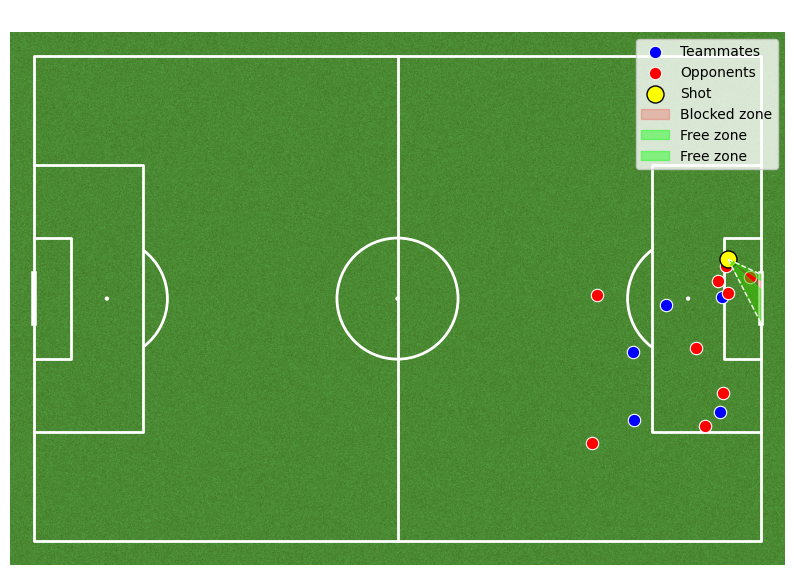

In [31]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Plot players
ax.scatter(teammate_x, teammate_y, c='blue', label='Teammates', s=80, edgecolors='white', linewidth=0.8)
ax.scatter(opponent_x, opponent_y, c='red', label='Opponents', s=80, edgecolors='white', linewidth=0.8)
ax.scatter(shot_x, shot_y, c='yellow', s=150, edgecolors='black', label='Shot')

# Goalpost lines
ax.plot([shot_x, left_post[0]], [shot_y, left_post[1]], color='white', linestyle='--', linewidth=1)
ax.plot([shot_x, right_post[0]], [shot_y, right_post[1]], color='white', linestyle='--', linewidth=1)

# --- Draw free and blocked angles ---
goal_x = 120
# full goal cone (red background)
ax.fill(
    [shot_x, left_post[0], right_post[0]],
    [shot_y, left_post[1], right_post[1]],
    color='red', alpha=0.2, label='Blocked zone'
)

# overlay free angles in green
for a1, a2 in free_angles:
    y1 = shot_y + np.tan(a1) * (goal_x - shot_x)
    y2 = shot_y + np.tan(a2) * (goal_x - shot_x)
    ax.fill([shot_x, goal_x, goal_x],
            [shot_y, y1, y2],
            color='lime', alpha=0.4, label='Free zone')


# Legend and title
ax.legend(loc='upper right')
plt.title("Freeze Frame: Player Positions and Shooting Angles", color="white")
plt.show()
plt.show()

## Now let's compute it for all the frames

In [32]:
import ast
def freeze_frame_to_stats(freeze_frame):
    freeze_frame = ast.literal_eval(freeze_frame)
    # Split into teammates and opponents
    teammates = [p for p in freeze_frame if p["teammate"]]
    opponents = [p for p in freeze_frame if not p["teammate"]]
    
    # Goalposts and helper constants
    GOAL_LEFT = np.array([120, 36])
    GOAL_RIGHT = np.array([120, 44])
    PLAYER_RADIUS = 1.0  # rough player blocking radius (m)

    def extract_xy(players):
        """Extract x,y arrays from a freeze frame list of dicts."""
        x = np.array([p["location"][0] for p in players])
        y = np.array([p["location"][1] for p in players])
        return np.column_stack((x, y))

    def angle_between(a, b):
        """Angle between vectors a and b."""
        dot = np.dot(a, b)
        return np.arccos(dot / (np.linalg.norm(a) * np.linalg.norm(b)))

    shot_loc = np.array([shot_x, shot_y])

    # Split teammates / opponents
    teammates = [p for p in freeze_frame if p["teammate"]]
    opponents = [p for p in freeze_frame if not p["teammate"]]
    opp_xy = extract_xy(opponents)
    team_xy = extract_xy(teammates)

    # Compute total shooting cone angle (goal angle)
    v_left = GOAL_LEFT - shot_loc
    v_right = GOAL_RIGHT - shot_loc
    goal_angle = angle_between(v_left, v_right)

    ### Distance to closest defender
    dists_to_def = np.linalg.norm(opp_xy - shot_loc, axis=1)
    dist_to_nearest_def = np.min(dists_to_def) if len(dists_to_def) > 0 else np.nan

    left_post_angle = np.arctan2(GOAL_LEFT[1] - shot_y, GOAL_LEFT[0] - shot_x)
    right_post_angle = np.arctan2(GOAL_RIGHT[1] - shot_y, GOAL_RIGHT[0] - shot_x)

    # We are going to assume a player is 1m wide
    #left side of body
    l_dx = opp_xy[:, 0] - shot_loc[0]
    l_dy = opp_xy[:, 1] - PLAYER_RADIUS/2 - shot_loc[1]
    l_opp_angles = np.arctan2(l_dy, l_dx)
    #right side of body
    r_dx = opp_xy[:, 0] - shot_loc[0]
    r_dy = opp_xy[:, 1] + PLAYER_RADIUS/2 - shot_loc[1]
    r_opp_angles = np.arctan2(r_dy, r_dx)

    # defender blocking intervals
    blocked = []
    for l, r in zip(l_opp_angles, r_opp_angles):
        # normalize each so left < right
        blocked.append(sorted([l, r]))

    # clip to only those that actually overlap the goal angle
    blocked = [
        [max(l, left_post_angle), min(r, right_post_angle)]
        for l, r in blocked
        if r > left_post_angle and l < right_post_angle
    ]

    # sort by starting angle
    blocked.sort(key=lambda x: x[0])

    # now merge overlapping blocked ranges
    merged = []
    for b in blocked:
        if not merged or b[0] > merged[-1][1]:
            merged.append(b)
        else:
            merged[-1][1] = max(merged[-1][1], b[1])

    # compute free (unblocked) angular segments
    free_angles = []
    cur = left_post_angle
    for b in merged:
        if b[0] > cur:
            free_angles.append([cur, b[0]])  # free gap before blocked zone
        cur = b[1]
    if cur < right_post_angle:
        free_angles.append([cur, right_post_angle])

    free_angles = np.array(free_angles)

    num_def_blocking = len(blocked)
    total_free_angle = np.sum(free_angles[:,1] - free_angles[:,0]) if len(free_angles) != 0 else 0 ##### Key metric
    percent_free_angle = total_free_angle / goal_angle
    
    ### Goalkeeper stats
    gk_idx = np.argmax(opp_xy[:, 0])

    gk_position = opp_xy[gk_idx]

    gk_off_line = 120-gk_position[1]
    gk_position_in_goal = 40-gk_position[0]
    angle_shot_to_gk = np.arctan2(gk_position[1]-shot_loc[1], gk_position[0]-shot_loc[0])
    
    return dist_to_nearest_def, num_def_blocking,total_free_angle,percent_free_angle,gk_off_line,gk_position_in_goal,angle_shot_to_gk


In [33]:
freeze_frames = pd.read_csv('freeze_frames.csv')
freeze_frame_stats = freeze_frames["shot_freeze_frame"].apply(freeze_frame_to_stats).apply(pd.Series)
freeze_frame_stats.columns = ["distance_nearest_defender","num_defenders_blocking","total_free_angle","percent_free_angle","gk_dist_off_line","gk_pos_in_goal","angle_shot_gk"]
freeze_frame_stats

distance_nearest_defender  num_defenders_blocking  total_free_angle  \
0                       3.269557                     2.0          0.564495   
1                       8.614523                     1.0          0.000000   
2                       4.742362                     1.0          0.579475   
3                      10.522357                     0.0          0.662204   
4                       3.471311                     2.0          0.000000   
...                          ...                     ...               ...   
45228                   6.985700                     0.0          0.662204   
45229                   3.255764                     0.0          0.662204   
45230                   4.070626                     1.0          0.587362   
45231                   4.964877                     1.0          0.547950   
45232                   4.522168                     2.0          0.000000   

       percent_free_angle  gk_dist_off_line  gk_pos_in_goal  angle_shot_gk  
0                0.852449              77.5           -79.0       1.116077  
1                0.000000              78.0           -76.0       1.407556  
2                0.875070              80.8           -78.6       0.958894  
3                1.000000              84.9           -64.2       2.988943  
4                0.000000              83.5           -78.3       0.681298  
...                   ...               ...             ...            ...  
45228            1.000000              80.1           -77.4       1.158386  
45229            1.000000              77.8           -75.9       1.422468  
45230            0.886980              82.9           -76.5       1.085174  
45231            0.827464              79.0           -77.5       1.201837  
45232            0.000000              83.9           -78.3       0.612538  

[45233 rows x 7 columns]

In [34]:
model_df_v2 = pd.concat([model_df,freeze_frame_stats],axis=1)

# Now we can train a new model built with these new features

In [36]:
X_2 = model_df_v2.loc[:, ~model_df_v2.columns.isin(["shot_outcome", "shot_statsbomb_xg"])]
X_2 = X_2.astype(float)
X_2 = X_2.drop("percent_free_angle",axis=1) ### Remove and see what happens
X_2 = sm.add_constant(X_2)

X_train_2, X_test_2 = X_2.iloc[train_indices], X_2.iloc[test_indices]

model_2 = sm.Logit(y_train, X_train_2).fit()
print(model_2.summary())
print()

y_pred_test_2 = model_2.predict(X_test_2)### Let's still test the model on the same test set as before
print("Logistic Loss:", log_loss(y_test,y_pred_test_2)) 
print("AUC:",roc_auc_score(y_test,y_pred_test_2))

Optimization terminated successfully.
         Current function value: 0.257413
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           shot_outcome   No. Observations:                33925
Model:                          Logit   Df Residuals:                    33902
Method:                           MLE   Df Model:                           22
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.1875
Time:                        16:27:00   Log-Likelihood:                -8732.7
converged:                       True   LL-Null:                       -10748.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        11.2766      1.856      6.077      0.000       7.

# Now let's compare the two models we created and statsbomb's predicted xG

In [37]:
stats_bomb_xg = model_df["shot_statsbomb_xg"].values[test_indices]
print("Model 1 Log Loss", log_loss(y_test,y_pred_test),"| Model 2 Log Loss",log_loss(y_test,y_pred_test_2),"| Statsbomb Log Loss",log_loss(y_test,stats_bomb_xg))

Model 1 Log Loss 0.26027681753949294 | Model 2 Log Loss 0.2539493876331461 | Statsbomb Log Loss 0.2462319361648128


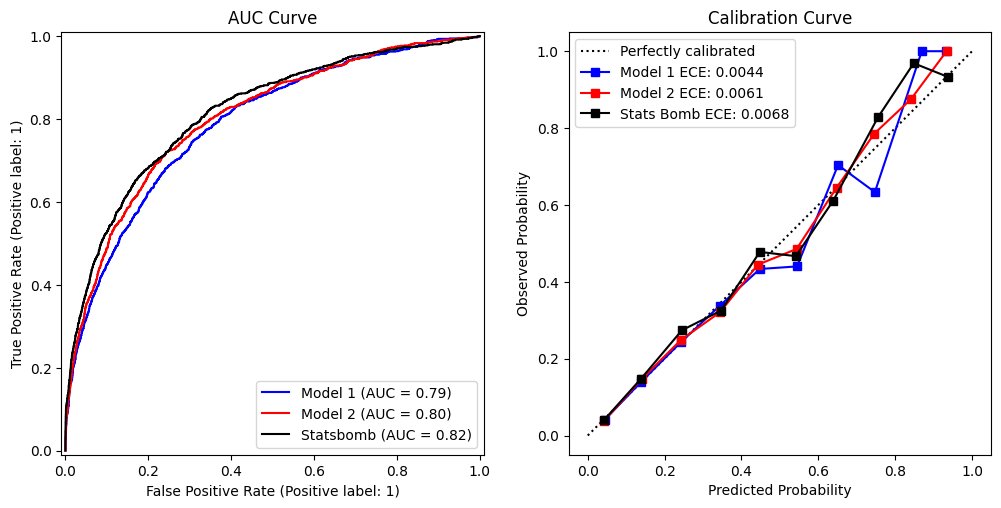

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))
ax[0].set_aspect('equal', adjustable='box') # roc curve
ax[1].set_aspect('equal', adjustable='box') # reliability diagram

# Your Code Here
# Use plot_roc_curve(), plot_reliability_diagram()
plot_roc_curve(y_test,y_pred_test,ax=ax[0],color="blue",label = "Model 1")
plot_reliability_diagram(y_test,y_pred_test,ax=ax[1],color="blue",label = f"Model 1 ECE: {round(compute_ece(y_test.values,y_pred_test.values),4)}")

plot_roc_curve(y_test,y_pred_test_2,ax=ax[0],color="red",label = "Model 2")
plot_reliability_diagram(y_test,y_pred_test_2,ax=ax[1],color="red",label = f"Model 2 ECE: {round(compute_ece(y_test.values,y_pred_test_2.values),4)}")

plot_roc_curve(y_test,stats_bomb_xg,ax=ax[0],color="black",label = "Statsbomb")
plot_reliability_diagram(y_test,stats_bomb_xg,ax=ax[1],color="black",label = f"Stats Bomb ECE: {round(compute_ece(y_test.values,stats_bomb_xg),4)}")

ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Observed Probability")
ax[1].set_title("Calibration Curve")

ax[0].set_title("AUC Curve")
plt.show()

# xG Model Results

We can see that all three models perform relatively well on the test sets with AUC's .79 and above. Our model that utilizes the freeze frames and computes freeze frame features performs better than our basic xG model. We can also see that all our models are pretty well calibrated and our xG estimates are reliable compared to the observed data. However, we do notice that as the predicted probability increases the calibration error does increase a bit possibly due to there being less shots with higher xG.

## Next, let's move onto baseball.

In [39]:
from pybaseball import statcast

In [38]:
# start_date = '2024-03-30'  #### Used to load data that is in statcast_2025.csv
# end_date = '2024-10-31'
# df = statcast(start_dt=start_date, end_dt=end_date)

In [40]:
df = pd.read_csv("statcast_2025_data.csv")
pd.set_option('display.max_columns', 200)

In [41]:
df

Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
0              167         KC  2024-10-30           77.5          -1.11   
1              177         KC  2024-10-30           78.7          -1.01   
2              184         FC  2024-10-30           93.1          -1.19   
3              189         KC  2024-10-30           78.5          -1.19   
4              205         KC  2024-10-30           77.4          -1.23   
...            ...        ...         ...            ...            ...   
714887        4051         FF  2024-03-30           91.4           0.57   
714888        4224         FF  2024-03-30           91.1           0.46   
714889        4403         CH  2024-03-30           81.8           0.88   
714890        4558         CH  2024-03-30           81.7           0.89   
714891        4639         FF  2024-03-30           90.6           0.63   

        release_pos_z      player_name  batter  pitcher     events  \
0                5.65  Buehler, Walker  657077   621111  strikeout   
1                5.73  Buehler, Walker  657077   621111        NaN   
2                5.53  Buehler, Walker  657077   621111        NaN   
3                5.70  Buehler, Walker  657077   621111        NaN   
4                5.78  Buehler, Walker  669224   621111  strikeout   
...               ...              ...     ...      ...        ...   
714887           6.16   Bradford, Cody  663538   674003  strikeout   
714888           6.21   Bradford, Cody  663538   674003        NaN   
714889           6.14   Bradford, Cody  663538   674003        NaN   
714890           6.09   Bradford, Cody  663538   674003        NaN   
714891           6.25   Bradford, Cody  663538   674003        NaN   

                    description  spin_dir  spin_rate_deprecated  \
0       swinging_strike_blocked       NaN                   NaN   
1               swinging_strike       NaN                   NaN   
2               swinging_strike       NaN                   NaN   
3                          ball       NaN                   NaN   
4               swinging_strike       NaN                   NaN   
...                         ...       ...                   ...   
714887            called_strike       NaN                   NaN   
714888                     foul       NaN                   NaN   
714889                     foul       NaN                   NaN   
714890          swinging_strike       NaN                   NaN   
714891                     ball       NaN                   NaN   

        break_angle_deprecated  break_length_deprecated  zone  \
0                          NaN                      NaN  13.0   
1                          NaN                      NaN  14.0   
2                          NaN                      NaN  14.0   
3                          NaN                      NaN  13.0   
4                          NaN                      NaN   7.0   
...                        ...                      ...   ...   
714887                     NaN                      NaN  11.0   
714888                     NaN                      NaN  12.0   
714889                     NaN                      NaN  12.0   
714890                     NaN                      NaN   9.0   
714891                     NaN                      NaN  14.0   

                                        des game_type stand p_throws  \
0        Alex Verdugo strikes out swinging.         W     L        R   
1                           Swinging Strike         W     L        R   
2                           Swinging Strike         W     L        R   
3                                      Ball         W     L        R   
4        Austin Wells strikes out swinging.         W     L        R   
...                                     ...       ...   ...      ...   
714887  Nico Hoerner called out on strikes.         R     R        L   
714888                                 Foul         R     R        L   
714889                          

### Predicting Batting Average based on Exit Velocity and Launch Angle!

- Can we see if players are getting lucky or unlucky? 
- xBA is a powerful tool to see the underlying batted ball characteristics, summed up into one metric, of a player. 
- Can be used to distinguish a player's strength and weaknesses, both pitchers and hitters. 

In [42]:
## Specify only batted balls
batted_ball_data = df[df['description'] == 'hit_into_play']
pd.set_option('display.max_columns', 200)

## What types of events are there in the batted_ball df?
print(batted_ball_data['events'].unique())

batted_ball_data.head()

['field_out' 'single' 'double' 'sac_fly' 'force_out' 'fielders_choice'
 'field_error' 'home_run' 'grounded_into_double_play' 'double_play'
 'fielders_choice_out' 'sac_bunt' 'triple' 'triple_play' nan
 'sac_fly_double_play' 'catcher_interf']


Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
11         289         KC  2024-10-30           77.6          -1.08   
16         263         ST  2024-10-30           79.4          -1.48   
28         158         FF  2024-10-30           95.4          -1.53   
29         165         FF  2024-10-30           95.3          -1.51   
36          75         SI  2024-10-30           95.3          -2.90   

    release_pos_z       player_name  batter  pitcher     events  \
11           5.75   Buehler, Walker  683011   621111  field_out   
16           5.81  Leiter Jr., Mark  669257   643410  field_out   
28           5.73      Weaver, Luke  571970   596133  field_out   
29           5.88      Weaver, Luke  606192   596133     single   
36           6.23    Treinen, Blake  519317   595014  field_out   

      description  spin_dir  spin_rate_deprecated  break_angle_deprecated  \
11  hit_into_play       NaN                   NaN                     NaN   
16  hit_into_play       NaN                   NaN                     NaN   
28  hit_into_play       NaN                   NaN                     NaN   
29  hit_into_play       NaN                   NaN                     NaN   
36  hit_into_play       NaN                   NaN                     NaN   

    break_length_deprecated  zone  \
11                      NaN   2.0   
16                      NaN  13.0   
28                      NaN   4.0   
29                      NaN  13.0   
36                      NaN   6.0   

                                                  des game_type stand  \
11  Anthony Volpe grounds out, third baseman Max M...         W     R   
16  Will Smith grounds out, third baseman Jazz Chi...         W     R   
28  Max Muncy flies out sharply to right fielder J...         W     L   
29  Teoscar Hernández singles on a ground ball to ...         W     R   
36  Giancarlo Stanton flies out to right fielder M...         W     R   

   p_throws home_team away_team type  hit_location      bb_type  balls  \
11        R       NYY       LAD    X           5.0  ground_ball      2   
16        R       NYY       LAD    X           5.0  ground_ball      0   
28        R       NYY       LAD    X           9.0     fly_ball      0   
29        R       NYY       LAD    X           7.0  ground_ball      0   
36        R       NYY       LAD    X           9.0     fly_ball      0   

    strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b     on_2b  \
11        2       2024   1.08  -1.47     0.05     2.97    NaN       NaN   
16        0       2024   0.91  -0.56    -0.83     2.10    NaN  621035.0   
28        0       2024  -0.37   1.50    -0.39     2.47    NaN       NaN   
29        2       2024  -0.38   1.40    -0.08     1.49    NaN       NaN   
36        0       2024  -1.51   0.04     0.30     3.02    NaN  592450.0   

       on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y  \
11       NaN             0       9           Bot   91.48  156.96   
16  571771.0             2       9           Top  103.48  161.25   
28  621035.0             0       9           Top  189.05   92.92   
29       NaN             0       9           Top   84.22  105.00   
36  665862.0             1       8           Bot  184.71  143.66   

    tfs_deprecated  tfs_zulu_deprecated  umpire  sv_id        vx0         vy0  \
11             NaN                  NaN     NaN    NaN   0.454191 -112.826142   
16             NaN                  NaN     NaN    NaN  -0.286591 -115.560896   
28             NaN                  NaN     NaN    NaN   3.801273 -138.574332   
29             NaN                  NaN     NaN    NaN   4.578072 -138.434266   
36             NaN                  NaN     NaN    NaN  11.657914 -138.211482   

         vz0         ax         ay         az  sz_top  sz_bot  \
11  3.851147   8.970525  25.000669 -45.651313    3.39    1.62   
16 -0.248288   8.121242  23.319663 -37.373709    3.26    1.50   
28 -6.129753  -5.774524  37.244688 -11.790163    2.99    1.48 

- Our target, binary outcome is

In [43]:
## Encode target variable of whether the ball in play was a hit or not.

batted_ball_data['is_hit'] = ~(batted_ball_data['events'].isin(['field_error', 'fielders_choice', 'grounded_into_double_play', 'double_play', 'fielders_choice_out', 'sac_bunt', 'triple_play', 'sac_fly_double_play', 'sac_fly', 'force_out', 'field_out', 'catcher_interf'])) * 1
batted_ball_data.head()

Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
11         289         KC  2024-10-30           77.6          -1.08   
16         263         ST  2024-10-30           79.4          -1.48   
28         158         FF  2024-10-30           95.4          -1.53   
29         165         FF  2024-10-30           95.3          -1.51   
36          75         SI  2024-10-30           95.3          -2.90   

    release_pos_z       player_name  batter  pitcher     events  \
11           5.75   Buehler, Walker  683011   621111  field_out   
16           5.81  Leiter Jr., Mark  669257   643410  field_out   
28           5.73      Weaver, Luke  571970   596133  field_out   
29           5.88      Weaver, Luke  606192   596133     single   
36           6.23    Treinen, Blake  519317   595014  field_out   

      description  spin_dir  spin_rate_deprecated  break_angle_deprecated  \
11  hit_into_play       NaN                   NaN                     NaN   
16  hit_into_play       NaN                   NaN                     NaN   
28  hit_into_play       NaN                   NaN                     NaN   
29  hit_into_play       NaN                   NaN                     NaN   
36  hit_into_play       NaN                   NaN                     NaN   

    break_length_deprecated  zone  \
11                      NaN   2.0   
16                      NaN  13.0   
28                      NaN   4.0   
29                      NaN  13.0   
36                      NaN   6.0   

                                                  des game_type stand  \
11  Anthony Volpe grounds out, third baseman Max M...         W     R   
16  Will Smith grounds out, third baseman Jazz Chi...         W     R   
28  Max Muncy flies out sharply to right fielder J...         W     L   
29  Teoscar Hernández singles on a ground ball to ...         W     R   
36  Giancarlo Stanton flies out to right fielder M...         W     R   

   p_throws home_team away_team type  hit_location      bb_type  balls  \
11        R       NYY       LAD    X           5.0  ground_ball      2   
16        R       NYY       LAD    X           5.0  ground_ball      0   
28        R       NYY       LAD    X           9.0     fly_ball      0   
29        R       NYY       LAD    X           7.0  ground_ball      0   
36        R       NYY       LAD    X           9.0     fly_ball      0   

    strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b     on_2b  \
11        2       2024   1.08  -1.47     0.05     2.97    NaN       NaN   
16        0       2024   0.91  -0.56    -0.83     2.10    NaN  621035.0   
28        0       2024  -0.37   1.50    -0.39     2.47    NaN       NaN   
29        2       2024  -0.38   1.40    -0.08     1.49    NaN       NaN   
36        0       2024  -1.51   0.04     0.30     3.02    NaN  592450.0   

       on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y  \
11       NaN             0       9           Bot   91.48  156.96   
16  571771.0             2       9           Top  103.48  161.25   
28  621035.0             0       9           Top  189.05   92.92   
29       NaN             0       9           Top   84.22  105.00   
36  665862.0             1       8           Bot  184.71  143.66   

    tfs_deprecated  tfs_zulu_deprecated  umpire  sv_id        vx0         vy0  \
11             NaN                  NaN     NaN    NaN   0.454191 -112.826142   
16             NaN                  NaN     NaN    NaN  -0.286591 -115.560896   
28             NaN                  NaN     NaN    NaN   3.801273 -138.574332   
29             NaN                  NaN     NaN    NaN   4.578072 -138.434266   
36             NaN                  NaN     NaN    NaN  11.657914 -138.211482   

         vz0         ax         ay         az  sz_top  sz_bot  \
11  3.851147   8.970525  25.000669 -45.651313    3.39    1.62   
16 -0.248288   8.121242  23.319663 -37.373709    3.26    1.50   
28 -6.129753  -5.774524  37.244688 -11.790163    2.99    1.48 

- Setting up our feature dataset before running our model. 

In [44]:
feature_cols = ['launch_speed', 'launch_angle']
target_cols = ['is_hit']
X = batted_ball_data[feature_cols + target_cols]
X = X.dropna()
X.head()

launch_speed  launch_angle  is_hit
11          92.4         -13.0       0
16         102.7           0.0       0
28         103.3          23.0       0
29          99.3           1.0       1
36          94.5          58.0       0

In [45]:
pd.set_option('display.float_format', '{:.3f}'.format)

### Logistic Generative Additive Model

- A logistic regression model assumes a linear relationship between the features and the target variable, in the log-odds space. 

### The Log-Odds Space

The log-odds space is where we fit a straight line to something that’s curved in probability space — allowing us to model hit probabilities accurately while keeping them between 0 and 1.

Instead of trying to model the probability of a hit by setting it equal to the coefficients of the features times the features, we do...

\[
\begin{aligned}
\text{logit}(p) &= \log\left(\frac{p}{1 - p}\right) \\
p &= \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots)}}
\end{aligned}
\]

\[
\begin{aligned}
\log\left(\frac{P(Y = \text{Hit})}{1 - P(Y = \text{Hit})}\right)
= \beta_0 &\quad + \beta_1 x_1 \quad + \beta_2 x_2 \\
\end{aligned}
\]

For a logistic regression model, the model can only make informed linear decisions in the feature space. This might mean that a +5 mph in EV has the same effect as a +5 degree increase in launch angle, which we know is not true. So, a generative additive model will replace the linear features with smooth, data-driven functions of those features, that take into account non-linear and localized effects. 

- The optimal launch angle is not found at 180 degrees or -180 degrees, there's a sweet spot around 15-25 degrees. 

In a LogisticGAM, you can use either "smooth" or "linear" functions (s or f) for each of your feature. We'll use smooth functions of EV and LA, respectively, to account for non-linear relationships between the featuers and the target variable.

In [46]:
from pygam import LogisticGAM, s, te

## We use numbers in our functions instead of column names because pyGAM works directly with numpy arrays, 
## so we need to index to find the feature cols in the dataframe rather than using the column name itself.

## .fit() is telling the model to learn the relationship between the first and second parameters.

gam = LogisticGAM(s(0) + s(1)).fit(X[feature_cols], X['is_hit'])

X['xBA'] = gam.predict_proba(X[feature_cols])

gam.partial_dependence(term=1, meshgrid=True)

X

launch_speed  launch_angle  is_hit   xBA
11            92.400       -13.000       0 0.105
16           102.700         0.000       0 0.463
28           103.300        23.000       0 0.673
29            99.300         1.000       1 0.384
36            94.500        58.000       0 0.017
...              ...           ...     ...   ...
714874        74.200       -36.000       0 0.096
714879        86.600        -7.000       1 0.125
714881       103.100         9.000       1 0.747
714882        86.700        64.000       0 0.008
714884        87.600        42.000       0 0.059

[124713 rows x 4 columns]

## Visualizing the xBA "Sweet Spot"

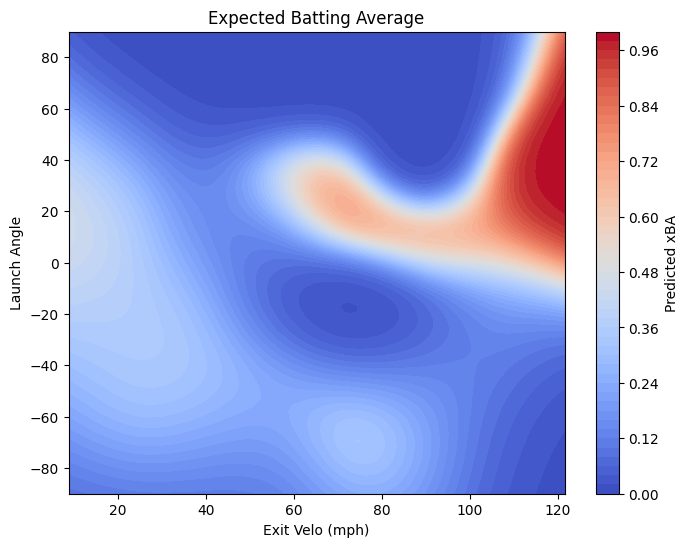

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LogisticGAM, te

feature_cols = ['launch_angle', 'launch_speed']

gam = LogisticGAM(te(0, 1)).fit(X[feature_cols], X['is_hit'])

X['xBA'] = gam.predict_proba(X[feature_cols])

la_min, la_max = X['launch_angle'].min(), X['launch_angle'].max()
ev_min, ev_max = X['launch_speed'].min(), X['launch_speed'].max()

la_vals = np.linspace(la_min, la_max, 80)
ev_vals = np.linspace(ev_min, ev_max, 80)
LA, EV = np.meshgrid(la_vals, ev_vals)

grid = np.column_stack([LA.ravel(), EV.ravel()])

Z = gam.predict_proba(grid).reshape(LA.shape)

plt.figure(figsize=(8, 6))
cp = plt.contourf(EV, LA, Z, levels=50, cmap='coolwarm')
plt.colorbar(cp, label='Predicted xBA')
plt.xlabel('Exit Velo (mph)')
plt.ylabel('Launch Angle')
plt.title('Expected Batting Average')
plt.show()

# Now we will get into how to value in game actions using Machine Learning

We will start by analyzing on the ball actions in soccer using the VAEP Framework. We will go back to using data from Statsbomb.

# VAEP Framework: Mathematical Formulation

VAEP (Valuing Actions by Estimating Probabilities) models the value of an action in a soccer game based on how it changes the probability of scoring or conceding a goal in the near future.

---

## 1. Probability of Scoring and Conceding

At each action \( a_t \), VAEP estimates two conditional probabilities given the current game state \( s_t \):

$$
P_{\text{score}}(t) = \Pr(\text{team scores within next } k \text{ seconds} \mid s_t)
$$

$$
P_{\text{concede}}(t) = \Pr(\text{team concedes within next } k \text{ seconds} \mid s_t)
$$

where \( k \) is a fixed short time horizon (e.g., 10 seconds).

---

## 2. Value of an Action

The value \( V(a_t) \) of an action \( a_t \) is defined as the difference between the expected scoring and conceding probabilities **after** and **before** the action:

$$
V(a_t) = \big( P_{\text{score}}(t+1) - P_{\text{score}}(t) \big) - \big( P_{\text{concede}}(t+1) - P_{\text{concede}}(t) \big)
$$

- The first term \( P_{\text{score}}(t+1) - P_{\text{score}}(t) \) measures how much the action increases the team’s chance to score.
- The second term \( P_{\text{concede}}(t+1) - P_{\text{concede}}(t) \) measures how much the action increases the opponent’s chance to score (conceding).

Thus, a **positive \( V(a_t) \)** means the action improves the team’s expected scoring chances relative to conceding, and vice versa.

---

## 3. Estimating Probabilities with Features

The state \( s_t \) is encoded by a feature vector \( \mathbf{x}_t \) extracted from the VAEP features described previously (e.g., locations, time, action type):

$$
\mathbf{x}_t = \text{FeatureVector}(a_t)
$$

Machine learning models (e.g., gradient boosting, neural nets) are trained to predict:

$$
\hat{P}_{\text{score}}(t) = f_{\text{score}}(\mathbf{x}_t)
$$

$$
\hat{P}_{\text{concede}}(t) = f_{\text{concede}}(\mathbf{x}_t)
$$

where \( f_{\text{score}} \) and \( f_{\text{concede}} \) are learned scoring functions.

---

## 4. Action Value in Terms of Predictions

Given model predictions for consecutive actions \( a_t \) and \( a_{t+1} \):

$$
\hat{V}(a_t) = \big( \hat{P}_{\text{score}}(t+1) - \hat{P}_{\text{score}}(t) \big) - \big( \hat{P}_{\text{concede}}(t+1) - \hat{P}_{\text{concede}}(t) \big)
$$

This can be computed for every action to assign a **VAEP score** reflecting its impact.

---

# Summary

| Equation                    | Description                                   |
|-----------------------------|-----------------------------------------------|
| \( P_{\text{score}}(t) \)      | Probability team scores soon after \( t \)        |
| \( P_{\text{concede}}(t) \)    | Probability team concedes soon after \( t \)      |
| \( V(a_t) \)                  | Action value: change in scoring minus conceding probabilities |
| \( \mathbf{x}_t \)            | Feature vector describing game state at \( t \)    |
| \( \hat{P} \)                | Model-predicted probabilities                    |

---

# VAEP Framework: Feature Descriptions

The VAEP framework uses a comprehensive set of features extracted from each soccer action to estimate its value. These features capture spatial, temporal, and contextual information about the action.

| **Feature Group**      | **Feature Name**           | **Description**                                                    |
|-----------------------|----------------------------|--------------------------------------------------------------------|
| **Action Type**       | `actiontype()`             | The type of the action performed.                                 |
|                       | `actiontype_onehot_ai`     | One-hot encoding of the action’s type.                            |
| **Result**            | `result()`                 | Result of the action (e.g., successful or not).                   |
|                       | `result_onehot_ai`         | One-hot encoding of the action’s result.                          |
| **Body Part**         | `bodypart()`               | The body part used to perform the action (e.g., foot, head).      |
|                       | `bodypart_onehot_ai`       | One-hot encoding of the body part used.                           |
| **Time**              | `time_ai`                  | The time in the match (in seconds) when the action took place.    |
| **Start Location**    | `start_x_ai`               | X-coordinate of the action’s starting location on the pitch.      |
|                       | `start_y_ai`               | Y-coordinate of the action’s starting location on the pitch.      |
| **End Location**      | `end_x_ai`                 | X-coordinate of the action’s ending location on the pitch.        |
|                       | `end_y_ai`                 | Y-coordinate of the action’s ending location on the pitch.        |
| **Start Polar Coordinates** | `start_dist_to_goal_ai`    | Distance from the start location to the center of the goal.       |
|                       | `start_angle_to_goal_ai`   | Angle between the start location and the center of the goal.      |
| **End Polar Coordinates**   | `end_dist_to_goal_ai`      | Distance from the end location to the center of the goal.         |
|                       | `end_angle_to_goal_ai`     | Angle between the end location and the center of the goal.        |
| **Movement**          | `dx_ai`                    | Distance covered by the action along the x-axis.                   |
|                       | `dy_ai`                    | Distance covered by the action along the y-axis.                   |
|                       | `movement_ai`              | Total distance covered by the action (combined x and y).          |
| **Team Possession**   | `team_ai`                  | Boolean indicating if the team keeps possession during the action.|
| **Time Delta**        | `time_delta_i`             | Seconds elapsed between the current and previous action.          |
| **Space Delta**       | `dx_a0i`                   | Distance covered along the x-axis between the current and previous action. |
|                       | `dy_a0i`                   | Distance covered along the y-axis between the current and previous action. |
|                       | `mov_a0i`                  | Total distance covered between the current and previous action.   |
| **Goal Score**        | `goalscore_team`           | Number of goals scored by the team executing the action.          |
|                       | `goalscore_opponent`       | Number of goals scored by the opposing team.                       |
|                       | `goalscore_diff`           | Goal difference between the two teams at the time of the action.  |

---

This rich set of features allows the VAEP model to capture important spatial, temporal, and contextual dynamics that influence the value of each action in a soccer game.

In [48]:
test_match_events["type"].unique()
valid_types = {"Pass","Carry","Dribble","Duel","Interception","Shot"}
valid_cols = ['carry_end_location','dribble_outcome', 'duel_outcome', 'duel_type', 'duration','id', 
              'index', 'interception_outcome', 'location', 'match_id', 'minute','pass_body_part', 
              'pass_cross', 'pass_cut_back','pass_end_location', 'pass_outcome',
              'pass_switch', 'pass_through_ball', 'pass_type',
              'period','player', 'player_id','second','shot_body_part','shot_outcome','team', 'team_id','timestamp', 'type']
events = test_match_events[test_match_events["type"].isin(valid_types)][valid_cols]
events.head()

carry_end_location dribble_outcome duel_outcome duel_type  duration  \
6                 NaN             NaN          NaN       NaN     0.453   
7                 NaN             NaN          NaN       NaN     1.996   
8                 NaN             NaN          NaN       NaN     1.415   
9                 NaN             NaN          NaN       NaN     1.068   
10                NaN             NaN          NaN       NaN     1.624   

                                      id  index interception_outcome  \
6   221b0c8d-6386-4ae8-bb4a-a1dc98742312      5                  NaN   
7   ff56e821-21e9-4cef-ba2a-7eb5eb3769c6      8                  NaN   
8   4464cb75-f45f-4508-8444-2560d1625d06     11                  NaN   
9   b88bbf46-30c8-4c60-b8cc-6d855f94f990     15                  NaN   
10  63a6070e-0c56-4615-8bab-8f6792d5562a     18                  NaN   

        location  match_id  minute pass_body_part pass_cross pass_cut_back  \
6   [61.0, 40.1]   3895302       0     Right Foot        NaN           NaN   
7   [59.0, 40.6]   3895302       0     Right Foot        NaN           NaN   
8   [35.1, 43.7]   3895302       0     Right Foot        NaN           NaN   
9   [32.7, 65.3]   3895302       0     Right Foot        NaN           NaN   
10  [44.5, 77.5]   3895302       0      Left Foot        NaN           NaN   

   pass_end_location pass_outcome pass_switch pass_through_ball pass_type  \
6       [59.0, 40.9]          NaN         NaN               NaN  Kick Off   
7       [35.1, 43.2]          NaN         NaN               NaN       NaN   
8       [33.2, 63.8]          NaN         NaN               NaN       NaN   
9       [44.5, 77.8]          NaN         NaN               NaN       NaN   
10      [62.2, 65.8]          NaN         NaN               NaN       NaN   

    period           player  player_id  second shot_body_part shot_outcome  \
6        1   Nick Woltemade  34870.000       3            NaN          NaN   
7        1   Marvin Ducksch  12299.000       4            NaN          NaN   
8        1   Christian Groß  31100.000       7            NaN          NaN   
9        1  Julián Malatini  51769.000      10            NaN          NaN   
10       1  Mitchell Weiser   8576.000      11            NaN          NaN   

             team  team_id     timestamp  type  
6   Werder Bremen      176  00:00:03.417  Pass  
7   Werder Bremen      176  00:00:04.732  Pass  
8   Werder Bremen      176  00:00:07.622  Pass  
9   Werder Bremen      176  00:00:10.352  Pass  
10  Werder Bremen      176  00:00:11.461  Pass

# Preprocessing

We need to combine many of these columns into one feature:

 - There are many outcome columns for different types

 - There are different event types categorized as subtypes

 - There are many columns for different body parts

In [49]:
events_map = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
    }

end_loc_cols = ["carry_end_location","pass_end_location"]

def get_end_loc(row):
    event_type = row["type"]
    if event_type not in {"Pass","Carry"}:
        return np.nan
    event_dict = events_map.get(event_type)
    if "end_loc" in event_dict:
        return row.get(event_dict["end_loc"], None)
    return np.nan

events["end_location"] = events.apply(get_end_loc, axis=1)

events = events.drop(end_loc_cols,axis=1)

outcome_cols = ["dribble_outcome","duel_outcome","interception_outcome","pass_outcome","shot_outcome"]

def get_outcome(row):
        event_type = row["type"]
        
        if event_type == "Carry":
            return 1
        event_dict = events_map.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1
        return np.nan
    
events["outcome"] = events.apply(get_outcome,axis=1)

events = events.drop(outcome_cols,axis=1)

type_cols = ["duel_type","pass_type","pass_cross","pass_cut_back","pass_switch","pass_through_ball"]

def get_type(row):
    curr_type = row["type"]
    if curr_type=="Pass":
        special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
        if row["pass_type"] in special_pass_types:
            return row["pass_type"]
        else:
            if row["pass_cross"]==True:
                return "Cross"
            elif row["pass_cut_back"]==True:
                return "Cut Back"
            elif row["pass_switch"]==True:
                return "Switch"
            elif row["pass_through_ball"]==True:
                return "Through Ball"
            else:
                return "Pass"
    elif curr_type == "Duel":
        if not pd.isna(row["duel_type"]):
            return row["duel_type"]
        else:
            return "Duel"
    return curr_type

events["type"] = events.apply(get_type,axis=1)

events = events.drop(type_cols,axis=1)

body_part_cols = ["pass_body_part","shot_body_part"]

events["body_part"] = events["pass_body_part"].combine_first(events["shot_body_part"])
events = events.drop(body_part_cols,axis=1)

In [50]:
events["start_x"] = events["location"].str[0]
events["start_y"] = events["location"].str[1]
events["end_x"] = events["end_location"].str[0]
events["end_y"] = events["end_location"].str[1]

events = events.drop(["location","end_location"],axis=1)
events.head()

duration                                    id  index  match_id  minute  \
6      0.453  221b0c8d-6386-4ae8-bb4a-a1dc98742312      5   3895302       0   
7      1.996  ff56e821-21e9-4cef-ba2a-7eb5eb3769c6      8   3895302       0   
8      1.415  4464cb75-f45f-4508-8444-2560d1625d06     11   3895302       0   
9      1.068  b88bbf46-30c8-4c60-b8cc-6d855f94f990     15   3895302       0   
10     1.624  63a6070e-0c56-4615-8bab-8f6792d5562a     18   3895302       0   

    period           player  player_id  second           team  team_id  \
6        1   Nick Woltemade  34870.000       3  Werder Bremen      176   
7        1   Marvin Ducksch  12299.000       4  Werder Bremen      176   
8        1   Christian Groß  31100.000       7  Werder Bremen      176   
9        1  Julián Malatini  51769.000      10  Werder Bremen      176   
10       1  Mitchell Weiser   8576.000      11  Werder Bremen      176   

       timestamp  type  outcome   body_part  start_x  start_y  end_x  end_y  
6   00:00:03.417  Pass        1  Right Foot   61.000   40.100 59.000 40.900  
7   00:00:04.732  Pass        1  Right Foot   59.000   40.600 35.100 43.200  
8   00:00:07.622  Pass        1  Right Foot   35.100   43.700 33.200 63.800  
9   00:00:10.352  Pass        1  Right Foot   32.700   65.300 44.500 77.800  
10  00:00:11.461  Pass        1   Left Foot   44.500   77.500 62.200 65.800

In [51]:
events.sort_values(["period","timestamp"])

duration                                    id  index  match_id  minute  \
6        0.453  221b0c8d-6386-4ae8-bb4a-a1dc98742312      5   3895302       0   
2333     0.863  77809242-1460-4395-8779-94a0cfc275b1      7   3895302       0   
7        1.996  ff56e821-21e9-4cef-ba2a-7eb5eb3769c6      8   3895302       0   
2334     0.894  cf9088bc-7e59-4d57-8ac5-31658da858bb     10   3895302       0   
8        1.415  4464cb75-f45f-4508-8444-2560d1625d06     11   3895302       0   
...        ...                                   ...    ...       ...     ...   
1176     0.199  b51cfe68-ebda-4c42-b315-79cdd9a3df5b   4210   3895302      89   
3353     5.075  6a3c49e3-5107-4e91-a5db-a20cb66156b8   4214   3895302      89   
1177     1.467  4e61f75d-564b-4478-a2f0-4b7e20e8600e   4216   3895302      89   
3354     2.499  91466764-aec7-4fac-a024-dd3deee3c737   4218   3895302      89   
4119     0.818  dcc0c591-7ebd-4e42-8206-04bfefa94f33   4220   3895302      89   

      period                     player  player_id  second              team  \
6          1             Nick Woltemade  34870.000       3     Werder Bremen   
2333       1             Marvin Ducksch  12299.000       3     Werder Bremen   
7          1             Marvin Ducksch  12299.000       4     Werder Bremen   
2334       1             Christian Groß  31100.000       6     Werder Bremen   
8          1             Christian Groß  31100.000       7     Werder Bremen   
...      ...                        ...        ...     ...               ...   
1176       2            Mitchell Weiser   8576.000      14     Werder Bremen   
3353       2  Alejandro Grimaldo García  10336.000      16  Bayer Leverkusen   
1177       2  Alejandro Grimaldo García  10336.000      21  Bayer Leverkusen   
3354       2              Florian Wirtz  40724.000      22  Bayer Leverkusen   
4119       2              Florian Wirtz  40724.000      25  Bayer Leverkusen   

      team_id     timestamp   type  outcome   body_part  start_x  start_y  \
6         176  00:00:03.417   Pass        1  Right Foot   61.000   40.100   
2333      176  00:00:03.870  Carry        1         NaN   59.000   40.900   
7         176  00:00:04.732   Pass        1  Right Foot   59.000   40.600   
2334      176  00:00:06.728  Carry        1         NaN   35.100   43.200   
8         176  00:00:07.622   Pass        1  Right Foot   35.100   43.700   
...       ...           ...    ...      ...         ...      ...      ...   
1176      176  00:44:14.465   Pass        0   Left Foot   97.100   57.200   
3353      904  00:44:16.038  Carry        1         NaN   30.900   21.700   
1177      904  00:44:21.113   Pass        1   Left Foot   66.100   27.300   
3354      904  00:44:22.580  Carry        1         NaN   89.400   55.400   
4119      904  00:44:25.079   Shot        1  Right Foot  106.400   48.800   

       end_x  end_y  
6     59.000 40.900  
2333  59.000 40.600  
7     35.100 43.200  
2334  35.100 43.700  
8     33.200 63.800  
...      ...    ...  
1176  97.500 55.000  
3353  66.100 27.300  
1177  89.400 55.400  
3354 106.400 48.800  
4119     NaN    NaN  

[2316 rows x 19 columns]

# Now we can collect and preprocess events from many games to build our training dataset

The code below processes and combines data from many games and leagues

In [52]:
# def preprocessing_soccer_events(events):
#     valid_types = {"Pass","Carry","Dribble","Duel","Interception","Shot"}
#     valid_cols = ['carry_end_location','dribble_outcome', 'duel_outcome', 'duel_type', 'duration','id', 
#                 'index', 'interception_outcome', 'location', 'match_id', 'minute','pass_body_part', 
#                 'pass_cross', 'pass_cut_back','pass_end_location', 'pass_outcome',
#                 'pass_switch', 'pass_through_ball', 'pass_type',
#                 'period','player', 'player_id','second','shot_body_part','shot_outcome','team', 'team_id','timestamp', 'type']
#     events = events[events["type"].isin(valid_types)][valid_cols]
    
#     end_loc_cols = ["carry_end_location","pass_end_location"]

#     def get_end_loc(row):
#         event_type = row["type"]
#         if event_type not in {"Pass","Carry"}:
#             return np.nan
#         event_dict = events_map.get(event_type)
#         if "end_loc" in event_dict:
#             return row.get(event_dict["end_loc"], None)
#         return np.nan

#     events["end_location"] = events.apply(get_end_loc, axis=1)

#     events = events.drop(end_loc_cols,axis=1)

#     outcome_cols = ["dribble_outcome","duel_outcome","interception_outcome","pass_outcome","shot_outcome"]

#     # events_map = {
#     #         "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
#     #         'Pass Offside'}}, 'end_loc': 'pass_end_location'},
#     #         "Carry": {'end_loc': 'carry_end_location'},
#     #         "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
#     #         "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
#     #         "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
#     #         "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
#     #     }
#     def get_outcome(row):
#             event_type = row["type"]
            
#             if event_type == "Carry":
#                 return 1
#             event_dict = events_map.get(event_type)
#             if "outcome" in event_dict:
#                 outcome_col = event_dict["outcome"]["col"]
#                 if row.get(outcome_col, None) in event_dict["outcome"][False]:
#                     return 0
#                 return 1
#             return np.nan
        
#     events["outcome"] = events.apply(get_outcome,axis=1)

#     events = events.drop(outcome_cols,axis=1)

#     type_cols = ["duel_type","pass_type","pass_cross","pass_cut_back","pass_switch","pass_through_ball"]

#     def get_type(row):
#         curr_type = row["type"]
#         if curr_type=="Pass":
#             special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
#             if row["pass_type"] in special_pass_types:
#                 return row["pass_type"]
#             else:
#                 if row["pass_cross"]==True:
#                     return "Cross"
#                 elif row["pass_cut_back"]==True:
#                     return "Cut Back"
#                 elif row["pass_switch"]==True:
#                     return "Switch"
#                 elif row["pass_through_ball"]==True:
#                     return "Through Ball"
#                 else:
#                     return "Pass"
#         elif curr_type == "Duel":
#             if not pd.isna(row["duel_type"]):
#                 return row["duel_type"]
#             else:
#                 return "Duel"
#         return curr_type

#     events["type"] = events.apply(get_type,axis=1)

#     events = events.drop(type_cols,axis=1)

#     body_part_cols = ["pass_body_part","shot_body_part"]

#     events["body_part"] = events["pass_body_part"].combine_first(events["shot_body_part"])
#     events = events.drop(body_part_cols,axis=1)
    
#     events["start_x"] = events["location"].str[0]
#     events["start_y"] = events["location"].str[1]
#     events["end_x"] = events["end_location"].str[0]
#     events["end_y"] = events["end_location"].str[1]

#     events = events.drop(["location","end_location"],axis=1)
    
#     return events

# ###### FINDING ALL EVENTS IN MANY LEAGUE GAMES

# dfs = []
# season_id = 27
# competition_ids = [9,11,7,2,12]
# for competition_id in competition_ids:
#     matches = sb.matches(competition_id,season_id)
#     for match_id in tqdm.tqdm(matches.match_id,"Finding Shots:"):
#         dfs.append(preprocessing_soccer_events(sb.events(match_id=match_id)))
# model_df_soccer_events = pd.concat(dfs)

# model_df_soccer_events.to_csv("soccer_events_processed.csv",index=False)

In [53]:
processed_events = pd.read_csv("soccer_events_processed.csv")
processed_events["timestamp"] = pd.to_timedelta(processed_events["timestamp"])

# Now we'll start computing some features

In [54]:
processed_events["time"] = processed_events["minute"]*60 + processed_events["second"]

#Distance of event
processed_events["distance"] = np.sqrt((processed_events["end_x"] - processed_events["start_x"])**2 + (processed_events["end_y"] - processed_events["start_y"])**2)
processed_events["angle"] = np.arctan2(processed_events["end_y"] - processed_events["start_y"],processed_events["end_x"] - processed_events["start_x"])


# How far in middle of field is an event
processed_events["start_distance_from_center"] = (processed_events['start_y']-40).abs()
processed_events['end_distance_from_center'] = (processed_events['end_y']-40).abs()

#distance from goal on end of event
processed_events['start_distance_from_goal'] = ((120-processed_events['start_x']).pow(2) + (40-processed_events['start_y']).pow(2)).pow(0.5)
processed_events['end_distance_from_goal'] = ((120-processed_events['end_x']).pow(2) + (40-processed_events['end_y']).pow(2)).pow(0.5)
# Calculate angle to goal from event end point 
processed_events['start_angle_to_goal'] = np.arctan2(40-processed_events['end_y'], 120-processed_events['end_x'])
processed_events['end_angle_to_goal'] = np.arctan2(40-processed_events['end_y'], 120-processed_events['end_x'])

processed_events = processed_events.sort_values(["match_id","period","timestamp"])

processed_events["event_before_same_team"] = processed_events.groupby(["match_id", "period"])["team_id"].shift(1) == processed_events["team_id"]

processed_events["dx_before"] = processed_events.groupby(["match_id", "period"])["start_x"].shift(0) - \
               processed_events.groupby(["match_id", "period"])["start_x"].shift(1)
processed_events["dy_before"] = processed_events.groupby(["match_id", "period"])["start_y"].shift(0) - \
               processed_events.groupby(["match_id", "period"])["start_y"].shift(1)

# Compute angle of movement in radians
processed_events["angle_before"] = np.arctan2(processed_events["dy_before"], processed_events["dx_before"])

processed_events["dist_before"] = np.sqrt(processed_events["dx_before"]**2 + processed_events["dy_before"]**2)

processed_events["time_before"] = processed_events.groupby(["match_id", "period"])["time"].shift(0) - \
               processed_events.groupby(["match_id", "period"])["time"].shift(1)

# Example: one-hot encode "type"
type_dummies = pd.get_dummies(processed_events["type"], prefix="type", drop_first=True)
dropped_type = processed_events["type"].unique().tolist()[0]  # the dropped (baseline) category

# Example: one-hot encode "body_part"
bodypart_dummies = pd.get_dummies(processed_events["body_part"], prefix="bodypart", drop_first=True)
dropped_bodypart = processed_events["body_part"].unique().tolist()[0]

# Combine encoded features back into your DataFrame
print("Dropped:",dropped_type,dropped_bodypart)
event_features = pd.concat([processed_events, type_dummies, bodypart_dummies], axis=1)

feature_cols =['duration', 'outcome', 'start_x', 'start_y', 'end_x', 'end_y', 'time',
       'distance', 'angle', 'start_distance_from_center',
       'end_distance_from_center', 'start_distance_from_goal',
       'end_distance_from_goal', 'start_angle_to_goal', 'end_angle_to_goal',
       'event_before_same_team', 'dx_before', 'dy_before', 'angle_before',
       'dist_before', 'time_before', 'type_Carry', 'type_Corner', 'type_Cross',
       'type_Dribble', 'type_Free Kick', 'type_Goal Kick', 'type_Interception',
       'type_Pass', 'type_Shot', 'type_Switch', 'type_Tackle', 'type_Throw-in',
       'bodypart_Head', 'bodypart_Keeper Arm', 'bodypart_Left Foot',
       'bodypart_No Touch', 'bodypart_Other', 'bodypart_Right Foot']

metadata_cols = ['id', 'index', 'match_id', 'minute', 'period', 'player',
       'player_id', 'second', 'team', 'team_id', 'timestamp', 'type',
       'outcome']

X = event_features[feature_cols]
meta_data = event_features[metadata_cols]

X

Dropped: Pass Right Foot


duration  outcome  start_x  start_y   end_x  end_y  time  distance  \
1256269     0.999        1   60.000   40.000  60.000 37.900     0     2.100   
1257328     0.202        1   60.000   37.900  57.100 39.000     1     3.102   
1256270     2.146        1   57.100   39.000  39.900 69.600     1    35.103   
1257329     1.094        1   39.900   69.600  40.300 65.300     3     4.319   
1256271     1.965        1   40.300   65.300  28.500 28.800     4    38.360   
...           ...      ...      ...      ...     ...    ...   ...       ...   
29497       4.185        1   94.300   64.500 103.500 58.400  5570    11.039   
29624       0.000        1   94.300   64.500     NaN    NaN  5570       NaN   
28823       0.796        1  103.500   58.400 111.100 53.900  5574     8.832   
29498       0.711        1  111.100   53.900 112.100 50.800  5575     3.257   
29668       0.288        0  112.100   50.800     NaN    NaN  5576       NaN   

         angle  start_distance_from_center  end_distance_from_center  \
1256269 -1.571                       0.000                     2.100   
1257328  2.779                       2.100                     1.000   
1256270  2.083                       1.000                    29.600   
1257329 -1.478                      29.600                    25.300   
1256271 -1.883                      25.300                    11.200   
...        ...                         ...                       ...   
29497   -0.585                      24.500                    18.400   
29624      NaN                      24.500                       NaN   
28823   -0.535                      18.400                    13.900   
29498   -1.259                      13.900                    10.800   
29668      NaN                      10.800                       NaN   

         start_distance_from_goal  end_distance_from_goal  \
1256269                    60.000                  60.037   
1257328                    60.037                  62.908   
1256270                    62.908                  85.394   
1257329                    85.394                  83.619   
1256271                    83.619                  92.183   
...                           ...                     ...   
29497                      35.507                  24.715   
29624                      35.507                     NaN   
28823                      24.715                  16.505   
29498                      16.505                  13.381   
29668                      13.381                     NaN   

         start_angle_to_goal  end_angle_to_goal  event_before_same_team  \
1256269                0.035              0.035                   False   
1257328                0.016              0.016                    True   
1256270               -0.354             -0.354                    True   
1257329               -0.307             -0.307                    True   
1256271                0.122              0.122                    True   
...                      ...                ...                     ...   
29497                 -0.840             -0.840                    True   
29624                    NaN                NaN                    True   
28823                 -1.001             -1.001                    True   
29498                 -0.939             -0.939                    True   
29668                    NaN                NaN                    True   

         dx_before  dy_before  angle_before  dist_before  time_before  \
1256269        NaN        NaN           NaN          NaN          NaN   
1257328      0.000     -2.100        -1.571        2.100        1.000   
1256270     -2.900      1.100         2.779        3.102        0.000   
1257329    -17.200     30.600         2.083       35.103        2.000   
1256271      0.400     -4.300        -1.478        4.319        1.000   
...            ...        ...           ...          ...          ...   
29497       -1.200      1.600         2.214       

# Now we will compute our target variable: A goal being scored in the next 10 seconds

The cell below takes 15 min to run so I have already run it and computed targets for you. They are stored in vaep_targets.csv

In [55]:
# goals = meta_data[(meta_data.type=="Shot") & (meta_data.outcome==1)]

# targets = pd.Series()
# for i,event in meta_data.iterrows():
#     id = event["id"]
#     match_id = event["match_id"]
#     period = event["period"]
#     timestamp = event["timestamp"]
#     team_id = event["team_id"]
    
#     goals_in_10 = goals[(goals["match_id"]==match_id) & (goals["period"]==period) & (goals["timestamp"]>=timestamp) & (goals["timestamp"]<=timestamp + pd.Timedelta(seconds=10))]
#     if goals_in_10.shape[0] ==1:
#         goal = goals_in_10.iloc[0]
#         goal_team_id = goal["team_id"]
        
#         if goal_team_id == team_id:
#             targets[id] = 1
#         else:
#             targets[id] = -1


In [56]:
# # Map the computed targets back into meta_data
# meta_data["vaep_target"] = meta_data["id"].map(targets)

# # Fill NaN values (events not leading to a goal in 10s) with 0
# meta_data["vaep_target"] = meta_data["vaep_target"].fillna(0)

In [57]:
vaep_targets = pd.read_csv("vaep_targets.csv")
vaep_targets.value_counts()

vaep_target
0.000          1259511
1.000            10227
-1.000             920
Name: count, dtype: int64

# Now we can train our model! We will be using XGBoost for this.

We will be training 2 models, one to model probability of scoring in next 10 seconds, and one to model probability of conceding in the next 10 seconds.

## 3. Estimating Probabilities with Features

The state \( s_t \) is encoded by a feature vector \( \mathbf{x}_t \) extracted from the VAEP features described previously (e.g., locations, time, action type):

$$
\mathbf{x}_t = \text{FeatureVector}(a_t)
$$

Machine learning models (e.g., gradient boosting, neural nets) are trained to predict:

$$
\hat{P}_{\text{score}}(t) = f_{\text{score}}(\mathbf{x}_t)
$$

$$
\hat{P}_{\text{concede}}(t) = f_{\text{concede}}(\mathbf{x}_t)
$$

where \( f_{\text{score}} \) and \( f_{\text{concede}} \) are learned scoring functions.

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
y = vaep_targets

y_goal = vaep_targets.clip(0,1)

y_concede = vaep_targets.clip(-1,0).abs()

##### Score model

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_goal, test_size=0.2, random_state=42, stratify=y_goal  # stratify if classification
)

# 2. Define model
xgb_score = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# 3. Fit model
xgb_score.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred_score = xgb_score.predict(X_test)

##### Concede Model

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_concede, test_size=0.2, random_state=42, stratify=y_concede  # stratify if classification
)

# 2. Define model
xgb_concede = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# 3. Fit model
xgb_concede.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred_concede = xgb_concede.predict(X_test)

# Now let's predict our scoring and conceding values for our dataset so that we can comptue our final VAEP Value

## 4. Action Value in Terms of Predictions

Given model predictions for consecutive actions \( a_t \) and \( a_{t+1} \):

$$
\hat{V}(a_t) = \big( \hat{P}_{\text{score}}(t+1) - \hat{P}_{\text{score}}(t) \big) - \big( \hat{P}_{\text{concede}}(t+1) - \hat{P}_{\text{concede}}(t) \big)
$$

In [58]:
meta_data["p_score"] = xgb_score.predict_proba(X)[:,1]
meta_data["p_concede"] = xgb_concede.predict_proba(X)[:,1]

meta_data["change_p_score"] = meta_data["p_score"] - meta_data.groupby(["match_id", "period"])["p_score"].shift(1)
meta_data["change_p_concede"] = meta_data["p_concede"] - meta_data.groupby(["match_id", "period"])["p_concede"].shift(1)

meta_data["VAEP_Value"] = meta_data["change_p_score"] - meta_data["change_p_concede"]

meta_data.head()

id  index  match_id  minute  \
1256269  f9706b37-a2b5-44a8-90ba-3cdb5aeaba1b      5    265839       0   
1257328  84258380-8bcc-4753-a4a9-453ce4bff450      7    265839       0   
1256270  8781c5e9-9557-4b9c-848a-b9074c3b2fbb      8    265839       0   
1257329  4f9c2d39-0ec2-4902-af40-f209dadf4dd6     10    265839       0   
1256271  6b6272c5-269f-4551-9bc5-51c55ed81be8     11    265839       0   

         period                         player  player_id  second       team  \
1256269       1       Luis Alberto Suárez Díaz   5246.000       0  Barcelona   
1257328       1  Neymar da Silva Santos Junior   4320.000       1  Barcelona   
1256270       1  Neymar da Silva Santos Junior   4320.000       1  Barcelona   
1257329       1             Aleix Vidal Parreu   6400.000       3  Barcelona   
1256271       1             Aleix Vidal Parreu   6400.000       4  Barcelona   

         team_id              timestamp   type  outcome  p_score  p_concede  \
1256269      217 0 days 00:00:00.509000   Pass        1    0.000      0.001   
1257328      217 0 days 00:00:01.508000  Carry        1    0.000      0.003   
1256270      217 0 days 00:00:01.710000   Pass        1    0.000      0.001   
1257329      217 0 days 00:00:03.855000  Carry        1    0.001      0.000   
1256271      217 0 days 00:00:04.950000   Pass        1    0.000      0.000   

         change_p_score  change_p_concede  VAEP_Value  
1256269             NaN               NaN         NaN  
1257328           0.000             0.002      -0.002  
1256270          -0.000            -0.002       0.002  
1257329           0.001            -0.000       0.001  
1256271          -0.001            -0.000      -0.001

# Quickly visualize the distribution of VAEP Values

Note: The y-axis here is log-scaled

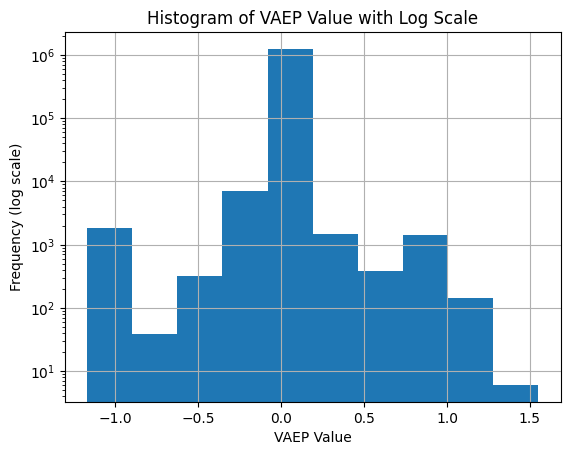

In [59]:
ax = meta_data["VAEP_Value"].hist()
ax.set_yscale('log')
plt.xlabel('VAEP Value')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of VAEP Value with Log Scale')
plt.show()

# Which players have the best on ball value?

Note: Our dataset is all events from Bundesliga	and La Liga in the 2015/16 season

In [60]:
meta_data.groupby("player")[["VAEP_Value"]].sum().sort_values(by="VAEP_Value",ascending=False)

VAEP_Value
player                                    
Lionel Andrés Messi Cuccittini      28.688
Neymar da Silva Santos Junior       27.671
Gareth Frank Bale                   23.304
Manuel Agudo Durán                  18.135
Antoine Griezmann                   17.052
...                                    ...
Felipe Salvador Caicedo Corozo     -20.317
Álvaro Vázquez García              -20.924
Deyverson Brum Silva Acosta        -21.934
Timo Werner                        -23.725
Anthony Ujah                       -23.797

[1010 rows x 1 columns]

# Now we will get into utilizing tracking data (Basketball) to predict probability of conceding points off a turnover

We will be using tracking data from the 2015/16 season. Available at https://huggingface.co/datasets/dcayton/nba_tracking_data_15_16 

In [58]:
from basketball_dataset.nba_tracking_data_15_16 import NbaTracking
import pandas as pd
import numpy as np

dataset = NbaTracking(config_name="tiny")
dataset.download_and_prepare("basketball_dataset/data")

In [59]:
nba_dataset = dataset.as_dataset()

In [60]:
nba_data = nba_dataset["train"].to_pandas()

In [61]:
nba_data.head()

gameid    gamedate                                         event_info  \
0  0021500333  2015-12-11  {'id': '1', 'type': 10, 'possession_team_id': ...   
1  0021500333  2015-12-11  {'id': '2', 'type': 1, 'possession_team_id': 1...   
2  0021500333  2015-12-11  {'id': '3', 'type': 1, 'possession_team_id': 1...   
3  0021500333  2015-12-11  {'id': '4', 'type': 2, 'possession_team_id': 1...   
4  0021500333  2015-12-11  {'id': '5', 'type': 4, 'possession_team_id': 1...   

                                        primary_info  \
0  {'team': 'home', 'player_id': 101133.0, 'team_...   
1  {'team': 'home', 'player_id': 101133.0, 'team_...   
2  {'team': 'away', 'player_id': 2547.0, 'team_id...   
3  {'team': 'home', 'player_id': 101145.0, 'team_...   
4  {'team': 'away', 'player_id': 202355.0, 'team_...   

                                      secondary_info  \
0  {'team': 'away', 'player_id': 202355.0, 'team_...   
1  {'team': 'home', 'player_id': 101145.0, 'team_...   
2   {'team': None, 'player_id': 0.0, 'team_id': nan}   
3   {'team': None, 'player_id': 0.0, 'team_id': nan}   
4   {'team': None, 'player_id': 0.0, 'team_id': nan}   

                                             visitor  \
0  {'name': 'Miami Heat', 'teamid': 1610612748, '...   
1  {'name': 'Miami Heat', 'teamid': 1610612748, '...   
2  {'name': 'Miami Heat', 'teamid': 1610612748, '...   
3  {'name': 'Miami Heat', 'teamid': 1610612748, '...   
4  {'name': 'Miami Heat', 'teamid': 1610612748, '...   

                                                home  \
0  {'name': 'Indiana Pacers', 'teamid': 161061275...   
1  {'name': 'Indiana Pacers', 'teamid': 161061275...   
2  {'name': 'Indiana Pacers', 'teamid': 161061275...   
3  {'name': 'Indiana Pacers', 'teamid': 161061275...   
4  {'name': 'Indiana Pacers', 'teamid': 161061275...   

                                             moments  
0  [{'quarter': 1, 'game_clock': 707.65, 'shot_cl...  
1  [{'quarter': 1, 'game_clock': 707.65, 'shot_cl...  
2  [{'quarter': 1, 'game_clock': 694.65, 'shot_cl...  
3  [{'quarter': 1, 'game_clock': 675.65, 'shot_cl...  
4  [{'quarter': 1, 'game_clock': 675.65, 'shot_cl...

In [65]:
nba_data["event_info"].iloc[0]

{'id': '1',
 'type': 10,
 'possession_team_id': None,
 'desc_home': 'Jump Ball Mahinmi vs. Whiteside: Tip to Allen',
 'desc_away': 'nan'}

# To start we will have to find the moment the turnover occurs for each turnover event

In [62]:
%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, Circle
from matplotlib.animation import FuncAnimation
import numpy as np
from basketball_dataset.dataset_operations import *


# --- Load a single event ---
filtered_events = filter_candidate_events(nba_dataset["train"]) #### Filter to just turnover events
event_num = 3
for i in range(event_num):
    event = next(iter(filtered_events))  # just pick one example

print(event['gameid'])
print(event['event_info']['id'])
print(event['event_info']['desc_home'])
print(event['event_info']['desc_away'])
# --- Setup figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Draw court ---
def draw_full_court(ax, color='black', lw=1):
    # Upper half
    court_elements = [
        Rectangle((0, 0), 50, 94, lw=lw, color=color, fill=False),
        
        Circle((25, 89.25), .85, lw=lw, color=color, fill=False),
        Rectangle((17, 75), 16, 19, lw=lw, color=color, fill=False),
        Rectangle((19, 75), 12, 19, lw=lw, color=color, fill=False),
        Arc((25, 75), 12, 12, theta1=180, theta2=0, lw=lw, color=color, fill=False),
        Arc((25, 75), 12, 12, theta1=0, theta2=180, lw=lw, color=color, linestyle='dashed'),
        Rectangle((3, 80), 0, 14, lw=lw, color=color),
        Rectangle((47, 80), 0, 14, lw=lw, color=color),
        Arc((25, 89.25), 47.5, 47.5, theta1=202, theta2=337.5, lw=lw, color=color),
        # Lower half mirrored
        Circle((25, 4.75), .85, lw=lw, color=color, fill=False),
        Rectangle((17, 0), 16, 19, lw=lw, color=color, fill=False),
        Rectangle((19, 0), 12, 19, lw=lw, color=color, fill=False),
        Arc((25, 19), 12, 12, theta1=0, theta2=180, lw=lw, color=color, fill=False),
        Arc((25, 19), 12, 12, theta1=180, theta2=0, lw=lw, color=color, linestyle='dashed'),
        Rectangle((3, 0), 0, 14, lw=lw, color=color),
        Rectangle((47, 0), 0, 14, lw=lw, color=color),
        Arc((25, 4.75), 47.5, 47.5, theta1=22.5, theta2=157.5, lw=lw, color=color),
        Rectangle((0, 47), 50, 0, lw=lw, color=color),  # half court
        Circle((25, 47), 6, lw=lw, color=color, fill=False)
    ]
    for e in court_elements:
        ax.add_patch(e)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 94)
    ax.set_aspect('equal')
    ax.axis('off')

draw_full_court(ax)

# --- Extract data ---
moments = event["moments"]
event_team = event["primary_info"]["team_id"]
event_player_id = event["primary_info"]["player_id"]

# --- Create plot handles for animation ---
ball, = ax.plot([], [], 'o', color='k', markersize=8)
players_attack, = ax.plot([], [], 'o', color='green', markersize=10)
players_defend, = ax.plot([], [], 'o', color='red', markersize=10)
handler, = ax.plot([], [], 'o', color='purple', markersize=12)

# --- Prepare frame update function ---
def update(frame):
    moment = moments[frame]
    attack_x, attack_y, defend_x, defend_y = [], [], [], []
    hx, hy = None, None

    for p in moment['player_coordinates']:
        if p['playerid'] == event_player_id:
            hx, hy = p['x'], p['y']
        elif p['teamid'] == event_team:
            attack_x.append(p['x'])
            attack_y.append(p['y'])
        else:
            defend_x.append(p['x'])
            defend_y.append(p['y'])
    
    ball.set_data(
        [moment['ball_coordinates']['x']],
        [moment['ball_coordinates']['y']]
    )
    players_attack.set_data(attack_x, attack_y)
    players_defend.set_data(defend_x, defend_y)
    
    if hx is not None:
        handler.set_data([hx], [hy])
    else:
        handler.set_data([], [])
    
    return ball, players_attack, players_defend, handler

# --- Animate ---
anim = FuncAnimation(fig, update, frames=len(moments), interval=60, blit=True)
plt.show()

0021500333
6
Mahinmi STEAL (1 STL)
Whiteside Lost Ball Turnover (P1.T1)


# Find the turnover

In [66]:
handler_has_ball = False
lost_possession = False

for moment in moments:
    event_team = event["primary_info"]["team_id"]
    event_player = event["primary_info"]["player_id"]

    for player_coord in moment['player_coordinates']:
        if player_coord['playerid'] == event_player:
          handler_x =player_coord["x"]
          handler_y = player_coord["y"]

    ball_x = moment['ball_coordinates']['x']
    ball_y = moment['ball_coordinates']['y']
    ball_spped = moment["ball_coordinates"]["speed"]
    
    if not lost_possession:
      if handler_has_ball == False:
        if np.linalg.norm(np.array([ball_x,ball_y])-np.array([handler_x,handler_y]))<2:
          print("gained possesion")
          handler_has_ball = True
      else:
        if np.linalg.norm(np.array([ball_x,ball_y])-np.array([handler_x,handler_y]))>5:
          lost_possession = True
          print("lost_possession")
    else:
      if ball_spped<3:
        print("ball controlled")
        break

gained possesion
lost_possession
ball controlled


# Turnover Frame

In [67]:
fig, ax = plt.subplots(figsize=(20, 20))
draw_full_court(ax=ax)

for player_coord in moment['player_coordinates']:
    if player_coord['playerid'] == event_player:
        handler_x =player_coord["x"]
        handler_y = player_coord["y"]
        c = 'purple'

    elif player_coord["teamid"]==event_team:
        c="green"
    else:
        c="r"
    plt.plot(player_coord['x'], player_coord['y'], 'o', markersize=10, color=c)
    
ball_x = moment['ball_coordinates']['x']
ball_y = moment['ball_coordinates']['y']

plt.plot(ball_x, ball_y, 'o', markersize=10, color='k')
plt.show()

# Find all turnovers and shots made after

In [ ]:
filtered_events = filter_candidate_events(nba_dataset["train"]) ### This cell takes about 1 min 50 sec to run
turnovers_and_shots = pd.DataFrame(filtered_events)

In [69]:
events = pd.json_normalize(turnovers_and_shots["event_info"])
events = pd.concat([events,turnovers_and_shots["primary_info"].apply(lambda prim_info: prim_info["team_id"])],axis=1).rename({"primary_info":"event_team"},axis=1)

In [70]:
game_turnovers = events[events["event_type"]=="turnover"]
for i, turnover in game_turnovers.iterrows():
    game_id = turnover["game_id"]
    quarter = turnover["quarter"]
    game_clock = turnover["game_clock"]
    shot_after = events[(events["game_id"]==game_id) & (events["quarter"]==quarter) & (events["event_type"]=="made shot") & (events["game_clock"]<game_clock) & (events["game_clock"]>=game_clock-10)] # Shot within 10 seconds of turnover
    if len(shot_after) >= 1:
        game_turnovers.loc[i,"made_shot_after"] = True
    else:
        game_turnovers.loc[i,"made_shot_after"] = False
game_turnovers.head()

id  type  possession_team_id                          desc_home  \
2    6     5      1610612748.000              Mahinmi STEAL (1 STL)   
4   15     5      1610612748.000              Mahinmi STEAL (2 STL)   
8   35     5      1610612754.000  G. Hill Bad Pass Turnover (P1.T2)   
15  64     5      1610612748.000                Ellis STEAL (1 STL)   
16  76     5      1610612748.000                 Hill STEAL (1 STL)   

                               desc_away direction  quarter  game_clock  \
2   Whiteside Lost Ball Turnover (P1.T1)     right        1     651.200   
4       Dragic Bad Pass Turnover (P1.T2)     right        1     607.990   
8                     Bosh STEAL (1 STL)      left        1     477.920   
15     Winslow Bad Pass Turnover (P1.T4)     right        1     278.720   
16        Wade Bad Pass Turnover (P2.T5)     right        1     218.530   

    shot_clock event_type     game_id  event_moment.quarter  \
2        2.790   turnover  0021500333                 1.000   
4        7.290   turnover  0021500333                 1.000   
8       19.820   turnover  0021500333                 1.000   
15      23.590   turnover  0021500333                 1.000   
16      19.230   turnover  0021500333                 1.000   

    event_moment.game_clock  event_moment.shot_clock  \
2                   651.200                    2.790   
4                   607.990                    7.290   
8                   477.920                   19.820   
15                  278.720                   23.590   
16                  218.530                   19.230   

    event_moment.ball_coordinates.x  event_moment.ball_coordinates.y  \
2                            37.959                           88.421   
4                            14.620                           92.354   
8                            25.086                            5.736   
15                           24.621                           67.785   
16                            2.153                           56.939   

    event_moment.ball_coordinates.z  event_moment.ball_coordinates.speed  \
2                             3.952                                2.727   
4                             1.156                                2.002   
8                            10.180                                0.255   
15                            6.527                                2.981   
16                            4.523                                6.109   

    event_moment.ball_coordinates.dir_x  event_moment.ball_coordinates.dir_y  \
2                                 0.226                                0.974   
4                                -0.776                                0.631   
8                                 0.773                               -0.634   
15                               -0.597                               -0.802   
16                                0.125                                0.992   

                      event_moment.player_coordinates     event_team  \
2   [{'teamid': 1610612754, 'playerid': 201588, 'x... 1610612748.000   
4   [{'teamid': 1610612754, 'playerid': 201588, 'x... 1610612748.000   
8   [{'teamid': 1610612754, 'playerid': 201588, 'x... 1610612754.000   
15  [{'teamid': 1610612754, 'playerid': 201588, 'x... 1610612748.000   
16  [{'teamid': 1610612754, 'playerid': 201155, 'x... 1610612748.000   

   made_shot_after  
2            False  
4            False  
8            False  
15           False  
16           False

# Now we'd do this for every game we have data for but I have already collected this for us

In [71]:
import pandas as pd
turnovers = pd.read_csv("turnovers.csv")

# Now we will build the features representing the turnover 

We will do this by representing the current situation after the turnover as a graph. We will then use the graph as input in a Graph Nueral Network to produce a logistic probability

In [72]:
import torch
from torch_geometric.data import Data
import ast  # for safely parsing stringified lists/dicts
import re

def build_graph_from_turnover(row):
    """
    Convert a single turnover event (dict) into a PyTorch Geometric Data object.

    Each player and the ball are nodes.
    - Players on the same team are fully connected.
    - Every player connects to the ball.
    """

    # --- Parse event info ---
    event_team = int(row["event_team"])  # the team responsible for turnover
    # Clean up the player coordinate string
    if type(row["event_moment.player_coordinates"]) == str:
        player_str = row["event_moment.player_coordinates"]

        # Replace patterns like "np.float64(1.2345)" → "1.2345"
        player_str = re.sub(r"np\.float64\(([^)]+)\)", r"\1", player_str)

        # Safely evaluate the cleaned string
        players = ast.literal_eval(player_str)
    else:
        players = row["event_moment.player_coordinates"]
    ball = {
        "x": row["event_moment.ball_coordinates.x"],
        "y": row["event_moment.ball_coordinates.y"],
        "z": row["event_moment.ball_coordinates.z"],
        "speed": row["event_moment.ball_coordinates.speed"],
        "dir_x": row["event_moment.ball_coordinates.dir_x"],
        "dir_y": row["event_moment.ball_coordinates.dir_y"],
    }

    # Collect unique team IDs
    team_ids = list(set(p["teamid"] for p in players))
    if len(team_ids) != 2:
        raise ValueError(f"Expected 2 teams, got {team_ids}")

    teamA_id = event_team
    teamB_id = [tid for tid in team_ids if tid != teamA_id][0]

    # --- Node features ---
    node_features = []
    node_ids = []

    for p in players:
        x, y = p["x"], p["y"]
        speed, dir_x, dir_y = float(p["speed"]), float(p["dir_x"]), float(p["dir_y"])
        is_ball = 0
        is_team_A = 1 if p["teamid"] == teamA_id else 0
        node_features.append([x, y, speed, dir_x, dir_y, is_ball, is_team_A])
        node_ids.append(p["playerid"])

    # Add the ball node
    bx, by = ball["x"], ball["y"]
    node_features.append([bx, by, ball["speed"], ball["dir_x"], ball["dir_y"], 1, 0])
    node_ids.append("ball")

    x = torch.tensor(node_features, dtype=torch.float)

    # --- Build edges ---
    n = len(node_features)
    edges_src, edges_dst = [], []

    # (1) Connect all players on the same team
    for i, pi in enumerate(players):
        for j, pj in enumerate(players):
            if i != j and pi["teamid"] == pj["teamid"]:
                edges_src.append(i)
                edges_dst.append(j)

    # (2) Connect every player to the ball
    ball_idx = len(node_features) - 1
    for i in range(len(players)):
        edges_src.extend([i, ball_idx])
        edges_dst.extend([ball_idx, i])

    edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)

    # --- Optional edge features (distance) ---
    edge_attr = []
    for i, j in zip(edges_src, edges_dst):
        dist = ((x[i, 0] - x[j, 0]) ** 2 + (x[i, 1] - x[j, 1]) ** 2).sqrt()
        edge_attr.append([dist.item()])
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Let's visualize our features now

In [73]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data):
    # Convert PyG graph to NetworkX
    G = to_networkx(data, to_undirected=True)

    # Extract node positions (x, y) from your features
    pos = {i: (data.x[i,0].item(), data.x[i,1].item()) for i in range(data.num_nodes)}

    # Color players by team, ball as red
    colors = ['red' if data.x[i,5] == 1 else  # is_ball
              ('blue' if data.x[i,6] == 1 else 'green')  # is_team_A
              for i in range(data.num_nodes)]

    plt.figure(figsize=(6,6))
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=400, edge_color='gray')
    plt.title("Graph Connectivity (Players + Ball)")
    plt.show()

In [74]:
graph = build_graph_from_turnover(turnovers.iloc[0])
visualize_graph(graph)

# Now we want to build our turnover model. We can use a Graph Nueral Network to predict the probability our turnover situation (A Graph) will lead to a goal

🏀 Turnover → Shot Made Prediction Pipeline
Overview

This pipeline builds a Graph Neural Network (GNN) to estimate the probability that a turnover event in a basketball game will eventually lead to a made shot. Each turnover is represented as a graph snapshot of player and ball positions, velocities, and directions at the moment of the turnover.

🔧 1. Data Preparation

Each row in the turnover dataset represents a unique game event. For every event:

The player coordinates and ball coordinates are extracted and parsed.

Speeds and directional unit vectors are precomputed from the tracking data.

Each player and the ball are represented as nodes in a graph.

We then connect nodes to form edges:

Players are connected to their teammates (intra-team edges).

Every player is connected to the ball (player–ball edges).

Optionally, edges may be created for players within a fixed spatial radius of one another.

🧩 2. Graph Construction

For each turnover, a PyTorch Geometric Data object is created containing:

Node features:

𝑥
,
𝑦
,
𝑠
𝑝
𝑒
𝑒
𝑑
,
𝑑
𝑖
𝑟
_
𝑥
,
𝑑
𝑖
𝑟
_
𝑦
,
𝑖
𝑠
_
𝑏
𝑎
𝑙
𝑙
,
𝑖
𝑠
_
𝑡
𝑒
𝑎
𝑚
𝐴
x,y,speed,dir_x,dir_y,is_ball,is_teamA

Edge index:
Defines which nodes are connected.

Edge attributes:
Typically the Euclidean distance between nodes.

These graphs are then batched into a dataset ready for GNN training.

🧠 3. Model Training

We define a Graph Neural Network (GNN) model, such as a GCNConv or GraphSAGE network, to learn from the turnover graphs.

Each graph is passed through the GNN to produce a graph-level embedding, which is fed into a linear classifier predicting:

𝑃
(
goal after turnover
)
∈
[
0
,
1
]
P(goal after turnover)∈[0,1]

Training optimizes this probability using a binary classification loss (e.g. Binary Cross Entropy).

📈 4. Evaluation & Inference

During evaluation, each turnover graph is fed into the trained model to obtain:

Probability of Shot Made
=
sigmoid
(
𝑓
𝜃
(
𝐺
)
)
Probability of Shot Made=sigmoid(f
θ
	​

(G))

The model outputs the likelihood that the turnover will result in a made shot in the following possession.

🚀 Summary

Run Pipeline Steps

Load and preprocess turnover data.

Build a graph for each event (players + ball).

Batch graphs into a PyTorch Geometric dataset.

Train a GNN to predict post-turnover goal probability.

Evaluate model accuracy and interpret learned spatial–temporal patterns.

In [75]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example wrapper: turn a dataframe row into a PyG Data object and label
def row_to_data(row):
    """
    Wraps your existing build_graph_from_turnover to add a label.
    Label here is graph-level binary target 'made_shot_after' (bool -> 0/1).
    """
    graph = build_graph_from_turnover(row)  # returns torch_geometric.data.Data
    # label: convert to int (0/1)
    lbl = int(bool(row.get("made_shot_after", False)))
    graph.y = torch.tensor([lbl], dtype=torch.long)  # graph-level label
    # optionally add an id
    graph.event_id = row.get("id", None)
    return graph

# --- Create dataset (list of Data objects) ---
def build_dataset_from_df(df, row_to_data_fn, max_items=None):
    graphs = []
    for i, row in df.iterrows():
        try:
            g = row_to_data_fn(row)
            graphs.append(g)
        except Exception as e:
            # skip problematic rows but print error for debugging
            print(f"Skipping row {i} due to {e}")
        if max_items and len(graphs) >= max_items:
            break
    return graphs

# --- Simple GNN model for graph classification ---
class GraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden=64, num_layers=3, dropout=0.2):
        super().__init__()
        # Use GCNConv; you can swap to GATConv or GraphConv easily
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.lin1 = torch.nn.Linear(hidden, hidden // 2)
        self.lin2 = torch.nn.Linear(hidden // 2, 2)  # binary classification (2 classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_attr = getattr(data, "edge_attr", None)
        # message passing
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # pool to graph-level representation
        # assume data.batch is provided by DataLoader
        x = global_mean_pool(x, data.batch)  # (batch_size, hidden)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.lin2(x)  # logits
        return out

# --- Training / evaluation helpers ---
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch)  # shape [batch_size, 2]
        labels = batch.y.view(-1).to(device)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        labels = batch.y.view(-1).to(device)
        loss = F.cross_entropy(logits, labels, reduction='sum')
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    return total_loss / total, correct / total, all_preds, all_labels

# --- Putting it together ---
def run_pipeline(turnovers_df, batch_size=16, max_items=None, epochs=20, lr=1e-3):
    # 1) build graphs
    graphs = build_dataset_from_df(turnovers_df, row_to_data, max_items=max_items)
    if len(graphs) == 0:
        raise RuntimeError("No graphs were created. Check build_graph_from_turnover and rows.")
    print(f"Built {len(graphs)} graphs")

    # 2) split
    train_idx, test_idx = train_test_split(np.arange(len(graphs)), test_size=0.2, random_state=42)
    train_graphs = [graphs[i] for i in train_idx]
    test_graphs = [graphs[i] for i in test_idx]

    # 3) DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

    # 4) model
    in_ch = graphs[0].x.shape[1]
    model = GraphClassifier(in_ch, hidden=64, num_layers=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # 5) train loop
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, test_loader, device)
        print(f"Epoch {epoch:02d} | Train loss {train_loss:.4f}, acc {train_acc:.3f} | Val loss {val_loss:.4f}, acc {val_acc:.3f}")

    return model, train_loader, test_loader

In [76]:
model,train_loader,test_loader = run_pipeline(turnovers)

Skipping row 851 due to malformed node or string on line 1: <ast.Name object at 0x000001A9D3466550>
Skipping row 1157 due to malformed node or string on line 1: <ast.Name object at 0x000001A9D3426690>
Skipping row 1291 due to malformed node or string on line 1: <ast.Name object at 0x000001A9D3444F50>
Built 1409 graphs
Epoch 01 | Train loss 0.5422, acc 0.789 | Val loss 0.5176, acc 0.791
Epoch 02 | Train loss 0.5363, acc 0.789 | Val loss 0.5283, acc 0.791
Epoch 03 | Train loss 0.5324, acc 0.789 | Val loss 0.5120, acc 0.791
Epoch 04 | Train loss 0.5229, acc 0.789 | Val loss 0.5105, acc 0.791
Epoch 05 | Train loss 0.5222, acc 0.789 | Val loss 0.5139, acc 0.791
Epoch 06 | Train loss 0.5181, acc 0.789 | Val loss 0.5244, acc 0.791
Epoch 07 | Train loss 0.5266, acc 0.789 | Val loss 0.5148, acc 0.791
Epoch 08 | Train loss 0.5283, acc 0.789 | Val loss 0.5186, acc 0.791
Epoch 09 | Train loss 0.5179, acc 0.789 | Val loss 0.5192, acc 0.791
Epoch 10 | Train loss 0.5206, acc 0.789 | Val loss 0.5270, 

## ***Important***  

We only have 1409 training points so the model generated is not 100% reliable. 

There also appears to be moments matched to turnover event where the moments don't repreent a turnover

# Now let's predict the probability of the turnover we viewed earlier leading to a made shot

In [77]:
model.eval()
with torch.no_grad():
    data = graph.to(device)
    logits = model(data)
    prob = torch.nn.functional.softmax(logits, dim=1)[0][1]
    print("Probability of leading to made shot:", prob.cpu().numpy())

Probability of leading to made shot: 0.24081245


# Let's play around with different turnovers

In [1]:
TURNOVER_NUM = 1 #### PICK A NUMBER BETWEEN 0 and 65 


test_turnover_event = turnovers_and_shots[turnovers_and_shots["event_info"].apply(lambda event: event["type"]==5)].iloc[TURNOVER_NUM]
test_turnover_moments = test_turnover_event["moments"]
test_turnover_df = game_turnovers.iloc[TURNOVER_NUM]
test_graph = build_graph_from_turnover(test_turnover_df)
model.eval()
with torch.no_grad():
    data = test_graph.to(device)
    logits = model(data)
    test_prob = torch.nn.functional.softmax(logits, dim=1)[0][1]

# --- Extract data ---
event_team = test_turnover_event["primary_info"]["team_id"]
event_player_id = test_turnover_event["primary_info"]["player_id"]

fig, ax = plt.subplots(figsize=(10, 10))
draw_full_court(ax)

# --- Create plot handles ---
test_ball, = ax.plot([], [], 'o', color='k', markersize=8)
test_players_attack, = ax.plot([], [], 'o', color='green', markersize=10)
test_players_defend, = ax.plot([], [], 'o', color='red', markersize=10)
test_handler, = ax.plot([], [], 'o', color='purple', markersize=12)

ax.set_title(f"Turnover Num {TURNOVER_NUM} | Prob(Shot): {test_prob:.3f}")

# --- Frame update function ---
def test_update(frame):
    moment = test_turnover_moments[frame]
    attack_x, attack_y, defend_x, defend_y = [], [], [], []
    hx, hy = None, None

    for p in moment['player_coordinates']:
        if p['playerid'] == event_player_id:
            hx, hy = p['x'], p['y']
        elif p['teamid'] == event_team:
            attack_x.append(p['x'])
            attack_y.append(p['y'])
        else:
            defend_x.append(p['x'])
            defend_y.append(p['y'])
    
    # Update positions
    test_ball.set_data(
        [moment['ball_coordinates']['x']],
        [moment['ball_coordinates']['y']]
    )
    test_players_attack.set_data(attack_x, attack_y)
    test_players_defend.set_data(defend_x, defend_y)

    if hx is not None:
        test_handler.set_data([hx], [hy])
    else:
        test_handler.set_data([], [])

    return test_ball, test_players_attack, test_players_defend, test_handler

# --- Animate ---
anim = FuncAnimation(fig, test_update, frames=len(test_turnover_moments), interval=60, blit=True)
plt.show()

NameError: name 'turnovers_and_shots' is not defined